In [90]:
pip install openpyxl

   ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.0 kB ? eta -:--:--
   ------------------ --------------------- 112.6/250.0 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 250.0/250.0 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sqlalchemy import select, Sequence, ScalarResult, Insert, Update
from sqlalchemy.orm import Session
from sqlalchemy.sql import text
from sqlalchemy import create_engine, event, MetaData,Table
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import text
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
SMART_DATABASE_USER = 'postgres'
SMART_DATABASE_PASSWORD = 'oT2-IDGrJ5yxP9C3'
SMART_DATABASE_SERVER = "127.0.0.1"
SMART_DATABASE_PORT=5433
SMART_DATABASE_DATABASE='postgres'

In [41]:
engine = create_engine(f'postgresql+psycopg2://{SMART_DATABASE_USER}:{SMART_DATABASE_PASSWORD}@{SMART_DATABASE_SERVER}:{SMART_DATABASE_PORT}/{SMART_DATABASE_DATABASE}', 
                       echo=False, connect_args={'options': '-c statement_timeout=15000'})
session = sessionmaker(autocommit=False, autoflush=False, bind=engine)


In [98]:
sql = text("""SELECT datname FROM pg_database 
WHERE datistemplate = false and datname not in ('postgres','connectlogs','connectsmart', 'owner') 
--and datname like 'belizeaudubonsocietyconnect%'
order by datname limit(300);""")
with engine.connect() as con:
    rows = con.execute(sql)
    databases = pd.DataFrame([_r._asdict() for _r in rows])

In [99]:
databases

datname
0                    aclac
1          amazonasconnect
2    angolapantheraconnect
3        aninigeriaconnect
4           anpperuconnect
..                     ...
282             zcpconnect
283             zimconnect
284        zslkenyaconnect
285     zslmongoliaconnect
286  zslparcdunigerconnect

[287 rows x 1 columns]

In [162]:
# select schema_name from information_schema.schemata;
sqlCas = text("""
        select current_database() as sitename, c.ca_uuid, min(c.label) as ca_name, cast(max(cl.datetime) as date) as last_change               	
        from
            connect.ca_info as c
            left join connect.change_log as cl on c.ca_uuid = cl.ca_uuid            		
    group by c.ca_uuid;""")
sqlDq = text("""
        select 
            current_database() as sitename, c.ca_uuid,
            count(dq.uuid) as dataqueue_count,
            cast(max(dq.uploaded_date) as date) as last_dq_upload, cast(max(dq.lastmodified_date) as date) as last_dq_change
        from
            connect.ca_info as c
            left join connect.data_queue as dq on c.ca_uuid = dq.ca_uuid
    group by c.ca_uuid;""")
sqlPatrol = text("""
        select 
            current_database() as sitename, c.ca_uuid,
            count(p.uuid) as patrol_count
        from
            connect.ca_info as c
            left join smart.patrol as p on p.ca_uuid = c.ca_uuid
    group by c.ca_uuid;""")

# Observations
sqlWaypoints = text("""
        select 
            current_database() as sitename, c.ca_uuid,
            count (w.uuid) as waypoint_count
        from
            connect.ca_info as c
            left join smart.waypoint as w on w.ca_uuid = c.ca_uuid		
    group by c.ca_uuid;""")

# Tracks
sqlTracks = text("""
    select current_database() as sitename, p.ca_uuid, count (t.uuid) as track_count, sum(t.distance) as track_distance from smart.track as t
        join smart.patrol_leg_day as pld on pld.uuid = t.patrol_leg_day_uuid
        join smart.patrol_leg as pl on pl.uuid = pld.patrol_leg_uuid
        join smart.patrol as p on p.uuid = pl.patrol_uuid
        where t.distance < 1000
        group by p.ca_uuid""");


In [163]:
allcas = []
for db in databases.iloc():
        print(db.datname)
        try:
            constr = f'postgresql+psycopg2://{SMART_DATABASE_USER}:{SMART_DATABASE_PASSWORD}@{SMART_DATABASE_SERVER}:{SMART_DATABASE_PORT}/{db.datname}'
            #print(constr)
            engine = create_engine(constr, echo=False, connect_args={'options': '-c statement_timeout=15000'})
            #print("engine created")
            with engine.connect() as con:
                #print("rowsCa")
                rowsCa = con.execute(sqlCas)
                
                #print("rowsDq")
                rowsDq = con.execute(sqlDq)
                
                #print("rowsPatrol")
                rowsPatrol = con.execute(sqlPatrol)
                
                #print("rowsWaypoint")
                rowsWaypoint = con.execute(sqlWaypoints)
                
                #print("rowsTracks")
                rowsTracks = con.execute(sqlTracks)
                #print("queries done")
                
                cas = pd.DataFrame([_r._asdict() for _r in rowsCa])
                dqs = pd.DataFrame([_r._asdict() for _r in rowsDq])
                patrols = pd.DataFrame([_r._asdict() for _r in rowsPatrol])
                waypoints = pd.DataFrame([_r._asdict() for _r in rowsWaypoint])
                #print("tracks")
                tracks = pd.DataFrame([_r._asdict() for _r in rowsTracks])
                
                if len(dqs.index) > 0:
                    #print("cas.merge(dqs")
                    cas = cas.merge(dqs, left_on=['sitename','ca_uuid'], right_on=['sitename','ca_uuid'])
                    
                if len(patrols.index) > 0:
                    #print("cas.merge(patrols")
                    cas = cas.merge(patrols, left_on=['sitename','ca_uuid'], right_on=['sitename','ca_uuid'])
                    
                if len(waypoints.index) > 0:
                    #print("cas.merge(waypoints")
                    cas = cas.merge(waypoints, left_on=['sitename','ca_uuid'], right_on=['sitename','ca_uuid'])
                
                if len(tracks.index) > 0:
                    #print("cas.merge(tracks")
                    cas = cas.merge(tracks, left_on=['sitename','ca_uuid'], right_on=['sitename','ca_uuid'])
                
                allcas.append(cas)            
        except Exception as e:
            print(f"Error when accessing {db.datname}")
            print(e)
            pass

aclac
amazonasconnect
angolapantheraconnect
aninigeriaconnect
anpperuconnect
aprilasiaconnect
arabianleopard
argentinaapnconnect
atewaforestconnect
bachmaconnect
baharihaiconnect
baharihaiconnect752
bajoconnect
balemountainconnect
bangkaruconnect
barrionuevoconnect
bayislandshnconnect
belizeaudubonconnect
belizeaudubonsocietyconnect
belizeconnect
belizeconnectaz
belizeearthranger
bhutanconnect7
biliconnect
biocarbonconnect
biot74connect
biotconnect
birdlifeukraineconnect
bluefinanceconnect
brazilkanindeconnect
calgaryzooconnect
cambodiaconnect
cambodiaconservationconnect
canadanwmb
carder
carpathiansconnect
cdassconnect
cfesconnect
cfzconnect
chemchemconnect
chileconnect753
chipembeleconnect
chumonrayconnect
cimadagascarconnect
clawsbotswanaconnect
coast4cconnect
codechococonnect
conafconnect
congoconnect
connectsmart0
connectsmart1
connectsmart3
connectsmart4
connectsmart5
connectsmart6
connectsmart7
connectsmart8
connectsmart9
connecttest
constechconnect
coralinaconnect
corpoamazonia

In [164]:
cas = pd.concat(allcas)
cas

sitename                               ca_uuid  \
0                   aclac  6b2bbd74-dc3e-4c86-91f3-cd0e60752acb   
0         amazonasconnect  b58cae58-a721-4682-91e7-4c1a91192e53   
1         amazonasconnect  d86019d9-21c3-42c6-93fb-8529428e563b   
0   angolapantheraconnect  72ae4167-436d-41e2-8a31-79a7b2d55371   
0       aninigeriaconnect  d872f7ba-6b27-44b3-9b35-0e6f2c9a435a   
..                    ...                                   ...   
6      zslmongoliaconnect  69ba3ddb-a39b-4523-9ffe-f12d00651915   
7      zslmongoliaconnect  e918160a-8ba6-4a0d-ab37-7b8a9b85c939   
8      zslmongoliaconnect  d9b260b5-91d3-4deb-9e9e-3793e8a3cf63   
9      zslmongoliaconnect  bcfd2bc2-3aa6-40bb-97b0-28bd77b8c80a   
0   zslparcdunigerconnect  7489e3ed-5940-4763-a3c1-48bd807421ea   

                                              ca_name last_change  \
0   Area de Conservacion Amistad Caribe, Limon,  C...  2024-02-17   
0                                 SEMA Amazonas [000]        None   
1                              RDS do Rio Negro [014]  2024-02-29   
0                             Luengue-Luiana [Angola]        None   
0                  Gashaka Gumti National Park [GGNP]  2024-03-06   
..                                                ...         ...   
6             Экологийн цагдаагийн алба-туршилт [ЦЕГ]        None   
7                         Mongolia Training CA [MTCA]        None   
8                 Экологийн цагдаагийн алба [Туршилт]        None   
9                        Khoid Mogoi gol - Teel [LPA]  2024-02-14   
0                                   Parc W Niger [WN]        None   

    dataqueue_count last_dq_upload last_dq_change  patrol_count  \
0              2463     2024-03-05     2024-03-05          1420   
0                 0           None           None             3   
1                 0           None           None             1   
0                 0           None           None           545   
0                 0           None           None           348   
..              ...            ...            ...           ...   
6                18     2023-12-15     2023-12-18             7   
7                 0           None           None             2   
8                 0           None           None            29   
9               394     2023-06-19     2023-06-19            66   
0                 0           None           None           646   

    waypoint_count  track_count  track_distance  
0             2825       1669.0      30263.0000  
0           213980          3.0         14.0422  
1                1          1.0        310.9920  
0            14362       1412.0      37335.8000  
0             3060       1249.0      24584.7000  
..             ...          ...             ...  
6                4          6.0       2113.3600  
7               31          4.0         27.0859  
8               36         51.0       5550.5100  
9              117         81.0       1750.8300  
0            17821       1065.0      39922.6000  

[1191 rows x 11 columns]

In [165]:
cas.to_excel('G:/My Drive/Smart/Documents/scaas-cas.xlsx')

In [4]:
cas = pd.read_excel('G:/My Drive/Smart/Documents/scaas-cas.xlsx')

In [9]:
server = pd.read_excel("C:/Users/OliverAdolph/Downloads/ScaaSv2 Sites(6).xlsx")
server

#                     Sitename  \
0      1.0              amazonasconnect   
1      2.0          argentinaapnconnect   
2      3.0          atewaforestconnect    
3      4.0             baharihaiconnect   
4      5.0          barrionuevoconnect    
..     ...                          ...   
284  285.0  marasianaconservancyconnect   
285  286.0                  cfesconnect   
286  287.0                   cfzconnect   
287  288.0       birdlifeUkraineConnect   
288    NaN                          NaN   

                                                   URL Alternate URLS  \
0    https://amazonasconnect.smartconservationtools...            NaN   
1    https://argentinaapnconnect.smartconservationt...            NaN   
2    https://atewaforestconnect.smartconservationto...            NaN   
3    https://baharihaiconnect.smartconservationtool...            NaN   
4    https://barrionuevoconnect.smartconservationto...            NaN   
..                                                 ...            ...   
284  https://marasianaconservancyconnect.smartconse...            NaN   
285  https://cfesconnect.smartconservationtools.org...            NaN   
286  https://cfzconnect.smartconservationtools.org/...            NaN   
287  https://birdlifeukraineconnect.smartconservati...            NaN   
288                                                NaN            NaN   

        Primary Contact                               email PC  \
0                   NaN                                    NaN   
1    Leonidas Lizárraga                  llizarraga@apn.gob.ar   
2                   NaN                                    NaN   
3                   NaN                                    NaN   
4          Omar Fleitas  barrionuevofleitasomardario@gmail.com   
..                  ...                                    ...   
284                 NaN                                    NaN   
285                 NaN                                    NaN   
286                 NaN                                    NaN   
287                 NaN                                    NaN   
288                 NaN                                    NaN   

                 Version                 Server.war MD5sum  \
0                  7.5.5  bc055bc5ec3f66f1c42087c9891d70f0   
1                  7.5.5                               NaN   
2                  7.5.5  bc055bc5ec3f66f1c42087c9891d70f0   
3    2022-03-06 00:00:00                               NaN   
4                  7.5.7  2561f9212d0ba2103388968762ece3cb   
..                   ...                               ...   
284                7.5.7  2561f9212d0ba2103388968762ece3cb   
285                7.5.7  2561f9212d0ba2103388968762ece3cb   
286                7.5.7  2561f9212d0ba2103388968762ece3cb   
287                7.5.7  2561f9212d0ba2103388968762ece3cb   
288                  NaN                               NaN   

          Migration Date InstallDate  ...           Container Instance  \
0    2022-03-27 00:00:00  2022-03-27  ...              amazonasconnect   
1    2022-03-31 00:00:00  2022-03-31  ...          argentinaapnconnect   
2    2022-03-24 00:00:00  2022-03-24  ...          atewaforestconnect    
3    2022-03-27 00:00:00         NaT  ...             baharihaiconnect   
4    2022-04-18 00:00:00  2022-04-18  ...          barrionuevoconnect    
..                   ...         ...  ...                          ...   
284  2024-02-19 00:00:00  2024-02-19  ...  marasianaconservancyconnect   
285  2024-02-28 00:00:00  2024-02-28  ...                  cfesconnect   
286  2024-02-28 00:00:00  2024-02-28  ...                   cfzconnect   
287  2024-03-01 00:00:00  2024-03-01  ...       birdlifeUkraineConnect   
288                  NaN         NaT  ...                          NaN   

    AJP Port HTTPS-Port Context Databaseserver Databasename  Filestorage  \
0       8042     8476.0  server            pg1          NaN          NaN   
1       8049     8483.0  server     

In [46]:
def read_docker(docker):
    filename = f"C:/Users/OliverAdolph/Downloads/2024-03-24-{docker}.json"
    df = pd.read_json(filename, lines=True)
    df['dockerserver'] = docker
    return df
dfContainer = pd.concat([read_docker('docker1'), read_docker('docker2'), read_docker('docker3'), read_docker('docker4'), read_docker('docker5'), read_docker('docker6'), read_docker('docker7'), read_docker('docker8')])    
dfContainer[['dockerserver','Names']]

dockerserver                       Names
0       docker1                 lamuconnect
1       docker1                 bajoconnect
2       docker1           mountelgonconnect
3       docker1     pantheramalaysiaconnect
4       docker1                  zcpconnect
..          ...                         ...
24      docker8               vigorous_nash
25      docker8  khamarhinosanctuaryconnect
26      docker8             wonegiziconnect
27      docker8               wwfijiconnect
28      docker8             constechconnect

[241 rows x 2 columns]

In [47]:
dfContainer.groupby('dockerserver')['Names'].count()

dockerserver
docker1    26
docker2    27
docker3    24
docker4    28
docker5    23
docker6    55
docker7    29
docker8    29
Name: Names, dtype: int64

In [10]:
server.where(server['Monitoring'] == 'Active').dropna(how='all') #['Sitename']

#                     Sitename  \
0      1.0              amazonasconnect   
1      2.0          argentinaapnconnect   
2      3.0          atewaforestconnect    
4      5.0          barrionuevoconnect    
6      7.0                belizeconnect   
..     ...                          ...   
283  284.0            wcsecuadorconnect   
284  285.0  marasianaconservancyconnect   
285  286.0                  cfesconnect   
286  287.0                   cfzconnect   
287  288.0       birdlifeUkraineConnect   

                                                   URL Alternate URLS  \
0    https://amazonasconnect.smartconservationtools...            NaN   
1    https://argentinaapnconnect.smartconservationt...            NaN   
2    https://atewaforestconnect.smartconservationto...            NaN   
4    https://barrionuevoconnect.smartconservationto...            NaN   
6    https://belizeconnect.smartconservationtools.o...            NaN   
..                                                 ...            ...   
283  https://wcsecuadorconnect.smartconservationtoo...            NaN   
284  https://marasianaconservancyconnect.smartconse...            NaN   
285  https://cfesconnect.smartconservationtools.org...            NaN   
286  https://cfzconnect.smartconservationtools.org/...            NaN   
287  https://birdlifeukraineconnect.smartconservati...            NaN   

        Primary Contact                               email PC Version  \
0                   NaN                                    NaN   7.5.5   
1    Leonidas Lizárraga                  llizarraga@apn.gob.ar   7.5.5   
2                   NaN                                    NaN   7.5.5   
4          Omar Fleitas  barrionuevofleitasomardario@gmail.com   7.5.7   
6            Julio Maaz                          jmaaz@wcs.org   7.5.5   
..                  ...                                    ...     ...   
283                 NaN                                    NaN   7.5.7   
284                 NaN                                    NaN   7.5.7   
285                 NaN                                    NaN   7.5.7   
286                 NaN                                    NaN   7.5.7   
287                 NaN                                    NaN   7.5.7   

                    Server.war MD5sum       Migration Date InstallDate  ...  \
0    bc055bc5ec3f66f1c42087c9891d70f0  2022-03-27 00:00:00  2022-03-27  ...   
1                                 NaN  2022-03-31 00:00:00  2022-03-31  ...   
2    bc055bc5ec3f66f1c42087c9891d70f0  2022-03-24 00:00:00  2022-03-24  ...   
4    2561f9212d0ba2103388968762ece3cb  2022-04-18 00:00:00  2022-04-18  ...   
6    bc055bc5ec3f66f1c42087c9891d70f0                  NaN         NaT  ...   
..                                ...                  ...         ...  ...   
283  2561f9212d0ba2103388968762ece3cb  2024-02-09 00:00:00  2024-02-09  ...   
284  2561f9212d0ba2103388968762ece3cb  2024-02-19 00:00:00  2024-02-19  ...   
285  2561f9212d0ba2103388968762ece3cb  2024-02-28 00:00:00  2024-02-28  ...   
286  2561f9212d0ba2103388968762ece3cb  2024-02-28 00:00:00  2024-02-28  ...   
287  2561f9212d0ba2103388968762ece3cb  2024-03-01 00:00:00  2024-03-01  ...   

              Container Instance AJP Port HTTPS-Port Context Databaseserver  \
0                amazonasconnect     8042     8476.0  server            pg1   
1            argentinaapnconnect     8049     8483.0  server            pg1   
2            atewaforestconnect      8040     8474.0  server            pg1   
4            barrionuevoconnect      8075     8509.0  server            pg1   
6                  belizeconnect     8053     8487.0     NaN            NaN   
..                           ...      ...        ...     ...            ...   
283            wcsecuadorconnect     8286     8717.0  server            pg1   
284  marasianaconservancyconnect     8287     8718.0  server            pg1   
285                  cfesconnect     8288     8719.0  server      

In [20]:
server.where(server['Monitoring'] != 'Active').dropna(how='all')

#                       Sitename  \
3      4.0               baharihaiconnect   
5      6.0    belizeaudubonsocietyconnect   
7      8.0               belizeconnectaz    
8      9.0            belizeconnect-scaas   
9     10.0                  bhutanconnect   
12    13.0                    biotconnect   
14    15.0                cambodiaconnect   
15    16.0                    canadanwmb    
17    18.0                   conafconnect   
19    20.0                    connectdemo   
21    22.0                connecttraining   
22    23.0          cotedivoireconnectzsl   
27    28.0              elsilencioconnect   
28    29.0               ewasolandscapeaz   
31    32.0             fiacambodiaconnect   
32    33.0  friendsofarabukosokekeconnect   
34    35.0                      fzszambia   
36    37.0                   gabonconnect   
38    39.0             gonarezhouconnect    
39    40.0                    gztconnect    
40    41.0                hondurasconnect   
41    42.0               indonesiaconnect   
42    43.0          iucnbangladeshconnect   
45    46.0          lionlandscapesconnect   
48    49.0                miljodirconnect   
49    50.0                 mtkenyaconnect   
51    52.0                 nigeriaconnect   
52    53.0                 pantherazambia   
53    54.0               pantherazambia63   
56    57.0             philippinesconnect   
57    58.0               preylangconnect    
60    61.0                        nagios4   
61    62.0                   lionrangerna   
62    63.0               SharedConnect630   
63    64.0               SharedConnect740   
64    65.0             smart75testconnect   
66    67.0               tanzaniaconnect    
70    71.0                  turkeyconnect   
74    75.0                 watamuconnect    
75    76.0                wcscongoconnect   
77    78.0                wcsgabonconnect   
79    80.0               wcshealthconnect   
82    83.0          wildchimpanzeeconnect   
83    84.0            wildhorizonsconnect   
85    86.0               wwfbhutanconnect   
88    89.0                     zimconnect   
89    90.0                zslkenyaconnect   
90    91.0            zslloisabaconnectaz   
92    93.0                    wwfcambodia   
117  118.0               kenyatraining752   
118  119.0            baharihaiconnect752   
123  124.0                sawctraining753   
133  134.0             bluefinanceconnect   
135  136.0              phalaborwaconnect   
222  223.0                     FACambodia   
230  231.0              calgaryzooconnect   
267  268.0                gfwsmartconnect   
278  279.0              fzsukraineconnect   
288    NaN                            NaN   

                                                   URL Alternate URLS  \
3    https://baharihaiconnect.smartconservationtool...            NaN   
5    https://belizeaudubonsocietyconnect.smartconse...            NaN   
7    https://belizeconnectaz.smartconservationtools...            NaN   
8    https://belizeconnect-scaas.smartconservationt...            NaN   
9    https://bhutanconnect.smartconservationtools.o...            NaN   
12   https://biotconnect.smartconservationtools.org...            NaN   
14   https://cambodiaconnect.smartconservationtools...            NaN   
15   https://canadanwmb.smartconservationtools.org:...            NaN   
17   https://conafconnect.smartconservationtools.or...            NaN   
19   https://connectdemo.smartconservationtools.org...            NaN   
21   https://connecttraining.smartconservationtools...            NaN   
22   https://cotedivoireconnectzsl.smartconservatio...            NaN   
27   https://elsilencioconnect.smartconservationtoo...            NaN   
28   https://ewasolandscapeaz.smartconservationtool...            NaN   
31   https://fiacambodiaconnect.smartconservationto...            NaN   
32   https://friendsofarabukosokekeconnect.smartcon...            NaN   
34   https://fzszambia.smartconservationtools.org:8...            N

In [171]:
df = cas.merge(server, left_on='sitename', right_on='Sitename')
#df = cas

In [172]:
df = dfContainer.merge(df, right_on='Sitename', left_on='Names', how='right')
#df.to_excel('C:/Users/OliverAdolph/Downloads/scaas-container.xlsx')
df[['Names', 'Sitename', 'dockerserver', 'last_change', 'CreatedAt', 'ca_uuid']]

Names               Sitename dockerserver last_change  \
0                     aclac                  aclac      docker4  2024-02-17   
1           amazonasconnect        amazonasconnect      docker5         NaT   
2           amazonasconnect        amazonasconnect      docker5  2024-02-29   
3     angolapantheraconnect  angolapantheraconnect      docker6         NaT   
4         aninigeriaconnect      aninigeriaconnect      docker6  2024-03-06   
...                     ...                    ...          ...         ...   
1019     zslmongoliaconnect     zslmongoliaconnect      docker6         NaT   
1020     zslmongoliaconnect     zslmongoliaconnect      docker6         NaT   
1021     zslmongoliaconnect     zslmongoliaconnect      docker6         NaT   
1022     zslmongoliaconnect     zslmongoliaconnect      docker6  2024-02-14   
1023  zslparcdunigerconnect  zslparcdunigerconnect      docker4         NaT   

                          CreatedAt                               ca_uuid  
0     2023-07-14 06:16:53 +0000 UTC  6b2bbd74-dc3e-4c86-91f3-cd0e60752acb  
1     2022-03-27 19:29:35 +0000 UTC  b58cae58-a721-4682-91e7-4c1a91192e53  
2     2022-03-27 19:29:35 +0000 UTC  d86019d9-21c3-42c6-93fb-8529428e563b  
3     2022-10-14 08:48:46 +0000 UTC  72ae4167-436d-41e2-8a31-79a7b2d55371  
4     2023-03-28 06:30:17 +0000 UTC  d872f7ba-6b27-44b3-9b35-0e6f2c9a435a  
...                             ...                                   ...  
1019  2022-10-14 09:07:23 +0000 UTC  69ba3ddb-a39b-4523-9ffe-f12d00651915  
1020  2022-10-14 09:07:23 +0000 UTC  e918160a-8ba6-4a0d-ab37-7b8a9b85c939  
1021  2022-10-14 09:07:23 +0000 UTC  d9b260b5-91d3-4deb-9e9e-3793e8a3cf63  
1022  2022-10-14 09:07:23 +0000 UTC  bcfd2bc2-3aa6-40bb-97b0-28bd77b8c80a  
1023  2022-07-27 10:28:15 +0000 UTC  7489e3ed-5940-4763-a3c1-48bd807421ea  

[1024 rows x 6 columns]

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Command                   900 non-null    object        
 1   CreatedAt                 900 non-null    object        
 2   ID                        900 non-null    object        
 3   Image                     900 non-null    object        
 4   Labels                    900 non-null    object        
 5   LocalVolumes              900 non-null    float64       
 6   Mounts                    900 non-null    object        
 7   Names                     900 non-null    object        
 8   Networks                  900 non-null    object        
 9   Ports                     900 non-null    object        
 10  RunningFor                900 non-null    object        
 11  Size                      900 non-null    object        
 12  State               

In [174]:
#df.groupby('Names')['last_change'].max().sort_values()
activity = df.groupby('Names').agg({'last_change': ['max'], 'last_dq_upload': ['max'], 'last_dq_change': ['max'],'CreatedAt': ['max'], 'ca_uuid': ['count']}).reset_index()
activity

Names last_change last_dq_upload last_dq_change  \
                                      max            max            max   
0                       aclac  2024-02-17     2024-03-05     2024-03-05   
1             amazonasconnect  2024-02-29            NaT            NaT   
2       angolapantheraconnect         NaT            NaT            NaT   
3           aninigeriaconnect  2024-03-06            NaT            NaT   
4              anpperuconnect         NaT     2023-05-12     2024-02-01   
..                        ...         ...            ...            ...   
182  wwfspainrabbitmonitoring  2024-02-28     2024-03-05     2024-03-05   
183             zambiaconnect  2024-03-06     2023-11-11     2023-11-11   
184                zcpconnect  2024-03-06            NaT            NaT   
185        zslmongoliaconnect  2024-03-02     2024-02-28     2024-03-06   
186     zslparcdunigerconnect         NaT            NaT            NaT   

                         CreatedAt ca_uuid  
                               max   count  
0    2023-07-14 06:16:53 +0000 UTC       1  
1    2022-03-27 19:29:35 +0000 UTC       2  
2    2022-10-14 08:48:46 +0000 UTC       1  
3    2023-03-28 06:30:17 +0000 UTC       2  
4    2022-12-21 05:12:23 +0000 UTC      55  
..                             ...     ...  
182  2022-05-17 20:47:02 +0000 UTC       7  
183  2022-10-14 09:12:43 +0000 UTC      25  
184  2023-07-28 04:31:34 +0000 UTC       7  
185  2022-10-14 09:07:23 +0000 UTC      10  
186  2022-07-27 10:28:15 +0000 UTC       1  

[187 rows x 6 columns]

In [176]:
#
#activity[activity.last_change.isnull() & activity.last_dq_upload.isnull() & activity.last_dq_change.isnull()]
#activity.dropna()
for row in activity.iloc():
    lc = row['last_change']['max']
    #print(lc)
    if pd.isnull(row['last_change']['max']) and pd.isnull(row['last_dq_upload']['max']) and pd.isnull(row['last_dq_change']['max']):
        print(f'Sitename: {row.Names[0]}, Created At:{row.CreatedAt[0]}, CAs: {row.ca_uuid[0]}')
        #print(row['last_change']['max'])

Sitename: angolapantheraconnect, Created At:2022-10-14 08:48:46 +0000 UTC, CAs: 1
Sitename: biliconnect, Created At:2022-03-04 14:24:06 +0000 UTC, CAs: 1
Sitename: biot74connect, Created At:2022-05-08 21:12:18 +0000 UTC, CAs: 1
Sitename: brazilkanindeconnect, Created At:2022-03-27 20:36:59 +0000 UTC, CAs: 2
Sitename: clawsbotswanaconnect, Created At:2022-12-02 03:22:57 +0000 UTC, CAs: 1
Sitename: connecttest, Created At:2022-05-06 07:54:08 +0000 UTC, CAs: 2
Sitename: constechconnect, Created At:2023-10-24 04:10:04 +0000 UTC, CAs: 1
Sitename: costanortehnconnect, Created At:2023-09-22 05:59:48 +0000 UTC, CAs: 1
Sitename: cuscoconnect, Created At:2023-07-28 04:18:33 +0000 UTC, CAs: 1
Sitename: czechconnect, Created At:2023-11-28 08:20:31 +0000 UTC, CAs: 1
Sitename: dnpwconnect, Created At:2023-12-04 12:09:29 +0000 UTC, CAs: 1
Sitename: durrellwcsmadagascar, Created At:2022-05-08 20:37:57 +0000 UTC, CAs: 5
Sitename: ecuadorconnect, Created At:2022-03-27 19:56:19 +0000 UTC, CAs: 1
Sitename

C:\Users\OliverAdolph\AppData\Local\Temp\ipykernel_34824\2000077423.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Sitename: {row.Names[0]}, Created At:{row.CreatedAt[0]}, CAs: {row.ca_uuid[0]}')


In [67]:
df_inactive = df.where((df['Monitoring'] != 'Active') | ((df['last_change'] == None) & (df['last_dq_upload'] == None) & (df['last_dq_change'] == None)) ).dropna(how='all') #['Sitename']
#df_inactive[['sitename','Monitoring','last_change','last_dq_upload','last_dq_change']]
#df_inactive.groupby('sitename')['sitename'].count() #.count()
df_inactive.groupby('sitename').agg({'ca_uuid': ['count'], 'patrol_count': ['sum'], 'waypoint_count': ['sum']}).reset_index()

sitename ca_uuid patrol_count waypoint_count
                                    count          sum            sum
0                baharihaiconnect       1        250.0          627.0
1                     biotconnect       2         12.0          238.0
2                 cambodiaconnect       5       6345.0       136718.0
3                    conafconnect       4        301.0         2226.0
4           cotedivoireconnectzsl       2       1941.0       125825.0
5               elsilencioconnect       1          0.0            0.0
6                ewasolandscapeaz      16      39142.0       259837.0
7              fiacambodiaconnect       2          9.0          307.0
8   friendsofarabukosokekeconnect       1          0.0            0.0
9                       fzszambia       2      24183.0       318183.0
10                   gabonconnect      18       4710.0       402007.0
11                hondurasconnect       2       2924.0         9814.0
12               indonesiaconnect       3       1536.0       155433.0
13               kenyatraining752       1          1.0           28.0
14          lionlandscapesconnect       3       9724.0        31556.0
15                   lionrangerna       1        595.0         1837.0
16                 mtkenyaconnect       4      37776.0       275574.0
17                 nigeriaconnect       1        200.0        14801.0
18              phalaborwaconnect       1          0.0            0.0
19                sawctraining753       1        294.0         1098.0
20             smart75testconnect      10       5328.0        17780.0
21                  turkeyconnect       1       2888.0          675.0
22               wcshealthconnect      12        857.0        17503.0
23            wildhorizonsconnect      12      13527.0        70804.0
24               wwfbhutanconnect       3       2425.0         9270.0
25                     zimconnect       7      14324.0       104799.0
26                zslkenyaconnect       2       3886.0        14400.0

In [68]:
#df_active = df.where((df['Monitoring'] == 'Active') & (df['last_change'] != None) & (df['last_dq_upload'] != None) & (df['last_dq_change'] != None) ).dropna(how='all') #['Sitename']
df_active = df.where((df['last_change'] != None) & (df['last_dq_upload'] != None) & (df['last_dq_change'] != None) ).dropna(how='all') #['Sitename']
date = '2023-1-01'
df['last_activity'] = df[['last_change', 'last_dq_change', 'last_dq_upload']].max(axis=1)
df_active = df.where((df['last_activity'] >= date)).dropna(how='all') 
df_active[['sitename','ca_uuid', 'last_activity']]

sitename                               ca_uuid  \
1                 bajoconnect  a511c531-1333-46d8-8701-8d76e3740d94   
2           mountelgonconnect  2b1ea803-5d4f-4220-ac95-9ed7d0952251   
4     pantheramalaysiaconnect  51653868-260d-45cc-a8ee-69590ff614ab   
5                  zcpconnect  512f9ab1-30ce-432b-a317-5b346980b02c   
6                  zcpconnect  6a62ccb1-3366-4a98-97cf-a16678e4a471   
...                       ...                                   ...   
1041            turkeyconnect  2bf4e4b8-3ebc-4132-ba8b-3d556d2e9153   
1058      wildhorizonsconnect  c534e325-9c11-42f4-adde-a492025471be   
1067         wwfbhutanconnect  b6fa5469-5600-47ec-bb56-c99603205124   
1068         wwfbhutanconnect  3b70877b-2a9b-46cf-87ae-271bef24a516   
1074               zimconnect  41d01a41-2702-4ac0-9fc1-4bde8fa58d01   

     last_activity  
1       2024-02-15  
2       2024-03-05  
4       2024-02-01  
5       2024-03-06  
6       2024-02-12  
...            ...  
1041    2023-08-10  
1058    2023-02-06  
1067    2023-03-23  
1068    2023-03-23  
1074    2023-05-07  

[589 rows x 3 columns]

array([<Axes: title={'center': 'ca_uuid'}, xlabel='Servername', ylabel='Number of CAs'>],
      dtype=object)

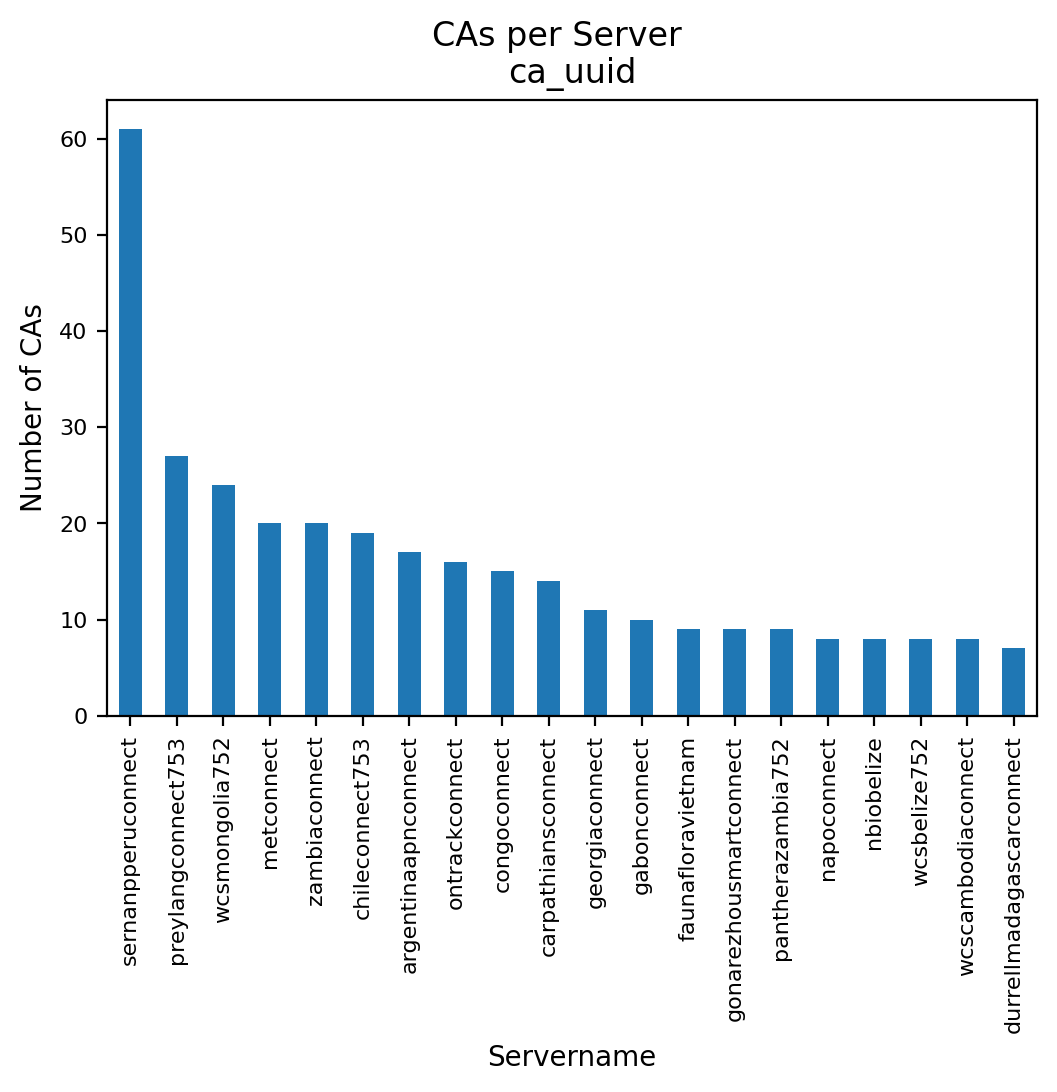

In [17]:
#df_active.groupby('sitename')['ca_uuid'].count().nlargest(n=30).plot.bar(x='sitename', y='count', legend=False)
fig = plt.figure(figsize=(6,4), dpi=200)
ax = plt.subplot(111)
fig = df_active.groupby('sitename')['ca_uuid'].count().nlargest(n=20).plot.bar(x='sitename', y='count', 
           fontsize=8, subplots=True, legend=False, ylabel='Number of CAs', title = 'CAs per Server', xlabel='Servername')
plt.savefig('G:/My Drive/Smart/Documents/sites-ca-count.png')
fig

In [18]:
df_inactive = df.where((df['last_activity'] < date)).dropna(how='all') 
df_inactive[['sitename','ca_uuid', 'last_activity']]

sitename                               ca_uuid last_activity
91       baharihaiconnect  246cc7ca-ee38-4317-9083-85735c510125    2022-12-30
108         belizeconnect  7c68b0c0-8482-47e1-aad2-a93affe0f7e2    2022-09-06
110         belizeconnect  846e1df1-96ea-4134-9e15-0edb96ba5987    2022-07-01
132           biotconnect  efa18141-f47a-41d9-b366-6561752ea82c    2021-11-25
139       cambodiaconnect  24a686d6-f30b-46b5-bc5d-dafb3a96ade3    2021-05-17
200          conafconnect  82ec3677-41f4-4ac0-a116-cacba6c6a0ec    2022-11-09
202          conafconnect  1843a076-92e1-4459-8b0e-034c472ecb2b    2022-12-07
264      ewasolandscapeaz  74658ccb-2a9c-460b-aeb4-8b25821c2715    2022-03-11
265      ewasolandscapeaz  63e881b8-5ff0-4515-a300-db1c7d783ae6    2022-10-13
268      ewasolandscapeaz  327bb825-e200-497d-a853-cb0c2cff5ad6    2022-08-20
269      ewasolandscapeaz  9c8f4986-9d0b-4008-8410-303d76aa0e1d    2022-10-16
270      ewasolandscapeaz  7e0d989e-315c-4f72-96fb-04fe467761d6    2022-06-17
273      ewasolandscapeaz  3d79842a-ff97-4e05-8a56-12ef4a14cef1    2022-05-24
276      ewasolandscapeaz  04bfd74f-3e8a-40bb-b9bf-884880531af6    2022-11-15
277      ewasolandscapeaz  7b8f1615-b221-4dcd-ba5c-403ca4db541c    2022-11-22
278      ewasolandscapeaz  8022431c-efc8-4cd9-8645-85a599b195b3    2022-10-03
297    fiacambodiaconnect  f6546579-a7b6-4602-b4d2-ec86276f36fe    2022-02-17
298    fiacambodiaconnect  f6546579-a7b6-4602-b4d2-ec86276f36fe    2022-02-17
321          gabonconnect  05d957d5-b702-4ce9-a8b8-99df92aa34db    2022-08-31
394      kenyatraining752  5ec71ef3-9492-4748-ba9a-c5fc7d13442b    2022-09-11
395      kenyatraining753  5ec71ef3-9492-4748-ba9a-c5fc7d13442b    2022-10-04
423          lionrangerna  a2516167-3da8-440e-b56b-6f68c2f11d53    2022-02-17
458        mtkenyaconnect  7ff3cf01-0de6-4548-bc92-7ec34a0939dd    2022-09-06
459        mtkenyaconnect  5031e7c9-563f-4263-989e-3a02261c19b1    2022-08-29
460        mtkenyaconnect  3929102f-5846-4019-8eed-24e28bbde916    2022-08-29
461        mtkenyaconnect  3f6d6e8e-d8e5-4f3e-98ea-bda579382a6a    2022-08-22
656     raorglatamconnect  056d0791-eaaa-4131-869f-2db924fc518e    2021-09-30
657     raorglatamconnect  17652618-8012-407e-aec9-bb9a9963dc80    2022-04-22
658     raorglatamconnect  dccb24a0-2dbe-494e-8ba7-4920fdb8ef43    2021-10-14
659     raorglatamconnect  b48813db-e781-4a83-88bb-8fd0ad1d48e2    2021-06-14
660     raorglatamconnect  d3ba17c8-2dc6-4da3-9ada-ac954d2e0ff2    2022-04-11
661     raorglatamconnect  e0261846-6ca0-4d37-a8cb-b12908f583b8    2022-04-26
662     raorglatamconnect  aba82cfd-b6e8-41b3-b23c-7f21e5d9c601    2021-04-17
663     raorglatamconnect  f451abb8-d1b5-43a0-839f-246613adfced    2022-04-28
664     raorglatamconnect  d4d31477-42d1-4164-8f18-6973a317118f    2021-07-05
665     raorglatamconnect  a9cac6f9-7da8-4591-868b-e7595adcfe89    2022-04-07
668     raorglatamconnect  c1a9e86d-3009-41f9-9ae8-de0d1d2179aa    2021-12-02
669     raorglatamconnect  29ab1e12-b964-45e0-9791-bb215977bd8f    2021-11-16
670     raorglatamconnect  a7cb575f-309e-4b01-8c49-5b1754d29918    2021-08-12
673     raorglatamconnect  86acaff0-8e67-48a7-b2e2-8a3ddc1e7df2    2022-04-26
684       sawctraining753  cd03f751-c1b5-4f82-b7c8-38d59505ec3a    2022-09-26
760    smart75testconnect  039b592c-57cc-4c06-b9b5-0ea92737627d    2022-12-09
799        testv74connect  4778e50d-a71d-4116-aeaf-799c4cb26b63    2022-07-11
801        testv74connect  6016b7ec-6fdc-4356-8d08-d2b5da7c8d8a    2022-07-04
847            wcsconnect  c644c4a2-b12c-4a37-979c-32473aaf2d61    2022-08-16
855      wcshealthconnect  ca3d2764-9c16-4848-a6f4-34c52dfbd465    2020-06-17
856      wcshealthconnect  edb12afd-14d7-4fae-a44e-17c29b7600fe    2020-11-23
857      wcshealthconnect  06ed4e44-f157-4dbc-88a6-79dcac94788f    2020-11-05
860      wcshealthconnect  b5441f32-dfd5-4778-8f0b-e7ecb175b6eb    2020-12-11
925   wildhorizonsconnect  b24843d1-59c1-491f-8629-b5fee287c3b3    2022-12-19
1013   zslmongoliaconnect  b0b14a73-2f5

<H1>Numbers</h1>

In [19]:
#df_active.groupby(['sitename', 'ca_name'])['patrol_count'].sum()
#df_active.groupby(['sitename'])['sitename'].count().sum()
#df_active['sitename'].value_counts()
index, counts = np.unique(df_active['sitename'],return_counts=True)
sitecount = len(index)
ca_count = counts.sum()
patrol_count = df_active['patrol_count'].sum()
waypoint_count = df_active['waypoint_count'].sum()
dataqueue_count = df_active['dataqueue_count'].sum()
print(f'Sites: {sitecount}')
print(f'CAs: {ca_count}')
print(f'Avg CA per Site: {ca_count/sitecount}')

print(f'Patrol Count: {patrol_count}')
print(f'Average Patrol Count per CA: {patrol_count/ca_count}')
print(f'Max Patrol Count: {df_active["patrol_count"].max()}')

print(f'Waypoint Count: {waypoint_count}')
print(f'Average Waypoint Count per CA: {waypoint_count/ca_count}')
print(f'Max Waypoint Count: {df_active["waypoint_count"].max()}')

print(f'Dataqueue Count: {dataqueue_count}')
print(f'Average Dataqueue Count per CA: {dataqueue_count/ca_count}')
print(f'Max Dataqueue Count: {df_active["dataqueue_count"].max()}')

print(f'Track Count: {df_active["track_count"].sum()}')
print(f'Covered Distance: {df_active["track_distance"].sum()}')


Sites: 152
CAs: 589
Avg CA per Site: 3.875
Patrol Count: 758087.0
Average Patrol Count per CA: 1287.074702886248
Max Patrol Count: 23417.0
Waypoint Count: 7711529.0
Average Waypoint Count per CA: 13092.578947368422
Max Waypoint Count: 701672.0
Dataqueue Count: 681058.0
Average Dataqueue Count per CA: 1156.295415959253
Max Dataqueue Count: 79181.0
Track Count: 1392483.0
Covered Distance: 26774976.73701462


In [317]:
cas.where(cas.patrol_count > 0).dropna(how='all')

sitename                               ca_uuid  \
0                   aclac  6b2bbd74-dc3e-4c86-91f3-cd0e60752acb   
6         amazonasconnect  b58cae58-a721-4682-91e7-4c1a91192e53   
44        amazonasconnect  d86019d9-21c3-42c6-93fb-8529428e563b   
0   angolapantheraconnect  72ae4167-436d-41e2-8a31-79a7b2d55371   
0       aninigeriaconnect  d872f7ba-6b27-44b3-9b35-0e6f2c9a435a   
..                    ...                                   ...   
6      zslmongoliaconnect  69ba3ddb-a39b-4523-9ffe-f12d00651915   
7      zslmongoliaconnect  e918160a-8ba6-4a0d-ab37-7b8a9b85c939   
8      zslmongoliaconnect  d9b260b5-91d3-4deb-9e9e-3793e8a3cf63   
9      zslmongoliaconnect  bcfd2bc2-3aa6-40bb-97b0-28bd77b8c80a   
0   zslparcdunigerconnect  7489e3ed-5940-4763-a3c1-48bd807421ea   

                                              ca_name last_change  \
0   Area de Conservacion Amistad Caribe, Limon,  C...  2024-02-17   
6                                 SEMA Amazonas [000]        None   
44                             RDS do Rio Negro [014]  2024-02-29   
0                             Luengue-Luiana [Angola]        None   
0                  Gashaka Gumti National Park [GGNP]  2024-03-03   
..                                                ...         ...   
6             Экологийн цагдаагийн алба-туршилт [ЦЕГ]        None   
7                         Mongolia Training CA [MTCA]        None   
8                 Экологийн цагдаагийн алба [Туршилт]        None   
9                        Khoid Mogoi gol - Teel [LPA]  2024-02-14   
0                                   Parc W Niger [WN]        None   

    dataqueue_count last_dq_upload last_dq_change  patrol_count  \
0            2420.0     2024-02-24     2024-02-26        1420.0   
6               0.0           None           None           3.0   
44              0.0           None           None           1.0   
0               0.0           None           None         545.0   
0               0.0           None           None         354.0   
..              ...            ...            ...           ...   
6              18.0     2023-12-15     2023-12-18           7.0   
7               0.0           None           None           2.0   
8               0.0           None           None          29.0   
9             394.0     2023-06-19     2023-06-19          66.0   
0               0.0           None           None         646.0   

    waypoint_count  
0           2825.0  
6         213980.0  
44             1.0  
0          14362.0  
0           3113.0  
..             ...  
6              4.0  
7             31.0  
8             36.0  
9            117.0  
0          17821.0  

[1127 rows x 9 columns]

<Axes: xlabel='sitename'>

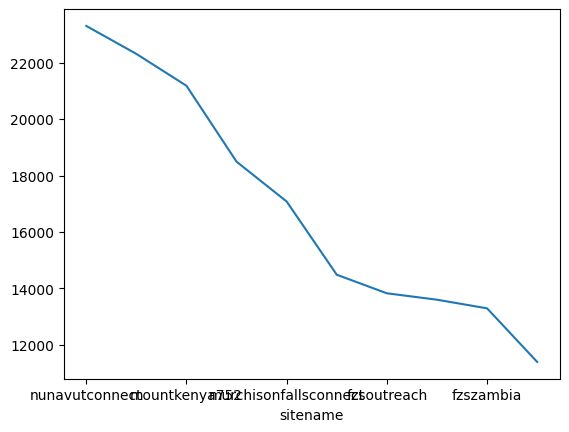

In [38]:
plt = df_active.nlargest(10, 'patrol_count').plot(x='sitename', y='patrol_count', legend=False)
#plt.xticks(rotation=45, ha='right')
plt

In [25]:
df_active.nlargest(20, 'dataqueue_count') #.plot.pie(y='patrol_count', x='sitename', legend=False)

Unnamed: 0                     sitename  \
516          0.0              kenyaconnectzsl   
599          3.0      mugieconservancyconnect   
1003         0.0            tsavotrustconnect   
542          0.0    lionguardianskenyaconnect   
957          4.0      smartpartnershipconnect   
733          2.0           preylangconnect753   
980         12.0  tacticaladvantageconnect752   
586          0.0            mountelgonconnect   
499          1.0                   ieaconnect   
967          0.0            somalilandconnect   
773         42.0           preylangconnect753   
1078         1.0          wcsguatemalaconnect   
1013         1.0         wcsbangladeshconnect   
800         69.0           preylangconnect753   
350          0.0     durrellmadagascarconnect   
543          0.0              lionlandscapes7   
186          3.0               bhutanconnect7   
760         29.0           preylangconnect753   
122         13.0          argentinaapnconnect   
231          1.0           carpathiansconnect   

                                   ca_uuid  \
516   2b1ea803-5d4f-4220-ac95-9ed7d0952251   
599   04bfd74f-3e8a-40bb-b9bf-884880531af6   
1003  b3116293-6ee5-4ca5-8ec7-c7b32e5a33f8   
542   8f7fbe1b-201a-4ef4-bda8-14f5581e65ce   
957   e4e0be5a-9336-48d0-9819-572ff2ea3838   
733   5dfe0392-4010-496a-9aab-f043186ddd28   
980   504fc01d-484b-431a-90c9-7019c3e30e5e   
586   2b1ea803-5d4f-4220-ac95-9ed7d0952251   
499   72fe4996-a8d4-41cb-8ef6-9d322baca65e   
967   6a3ac644-f3ff-445c-9112-2fc7c5ca2b1a   
773   33577ae3-496d-4535-9cec-0d202afb4d63   
1078  ea62b722-cdda-4207-96f0-d6b6ea2eb065   
1013  33020da2-5ab6-45f9-9355-b33df8817735   
800   9198f850-c049-4a65-8f35-ae1eb6a293d8   
350   03486a57-d1dc-438e-a304-47b5a990dc8c   
543   de185b0a-395f-441b-b5bf-e0ff39716f7c   
186   ccc1e346-519a-41dc-a615-bc5c674d9502   
760   cf6df214-d0b9-49df-bfd3-8f22635b0b85   
122   63cff6e2-9bb6-4fe7-a4c0-8e6a33ac4c56   
231   619ce412-9698-44b3-8886-52b3cdbe654e   

                                                ca_name last_change  \
516                   MT.ELGON ELEPHANT PROJECT [SMART]         NaT   
599                           Mugie Conservancy [Mugie]  2024-02-12   
1003                                   Tsavo Trust [TT]         NaT   
542                            Lion Gurdians [Amboseli]         NaT   
957                       Banka Forest Division [BANKA]         NaT   
733             Kulen Promtep Wildlife Sanctuary [KPWS]         NaT   
980               Wildlife Conservation Coalition [WCC]  2024-02-13   
586                   MT.ELGON ELEPHANT PROJECT [SMART]         NaT   
499                      LWW_LAZIO CONSERV AREA [ITALY]  2024-02-26   
967                                    Somaliland [CCF]  2024-03-02   
773                                 Mlu Prey Kerb [CPA]         NaT   
1078  Sistema Guatemalteco de Áreas Protegidas [REG_...  2024-03-01   
1013                               Marine SMART [CSFSN]         NaT   
800                                      Datavoek [CPA]         NaT   
350   Patrouilles pour gardiennage d'angonoka [Angon...         NaT   
543                                  Laikipa [laikipia]  2024-02-15   
186                                       Sarpang [DFO]  2024-01-24   
760                                       Tangyou [CPA]         NaT   
122   Parque Nacional Ansenuza y Reserva Nacional An...         NaT   
231                             Uzhanskyi_NNP [UA_Carp]  2024-02-28   

      dataqueue_count last_dq_upload last_dq_change  patrol_count  \
516           79181.0     2023-08-30     2023-09-06        2577.0   
599           41398.0     2024-02-26     2024-02-26        8075.0   
1003          41252.0     2023-10-20     2023-10-20        5888.0   
542           20888.0     2024-03-03     2024-03-03         922.0   
957           19381.0     2024-02-13     2024-02-13         221.0   
733           18227.0     2023-05-10     2023-05-10        3798.0   
980           11972.0     2024-03-

In [ ]:
<h1>Identify inactive Sites</h1>

In [363]:
#df_active.apply(lambda x: x.last_change if x.last_change > x.last_dq_upload else x.last_dq_upload, axis = 1)
df_active['last_activity'] = pd.to_datetime(df_active[['last_dq_change', 'last_dq_upload', 'last_change']].bfill(axis=1).iloc[:, 0])
df_active.groupby('sitename')['last_activity'].max().to_frame().where('last_activity')
#.sort_values('last_activity', ascending=False)


ValueError: Array conditional must be same shape as self

<h1>Data from Logfiles</h1>

In [26]:
def parse_grep(filename):
    result = []
    with open(filename) as f:
        for line in f:
            match = re.search('/smart/(.*)/logs/localhost_access_log\.(.*)\.txt\:(.*)', line)
            if match:
                d = dict()
                d['sitename'] = match[1]
                d['date'] = match[2]
                d['count'] = int(match[3])
                result.append(d)
            #else:
            #    print (line)
    
    df = pd.DataFrame(result)
    df['date'] = pd.to_datetime(df['date'])
    return df

In [235]:
dq_uploads = parse_grep("G:/My Drive/Smart/Documents/dq_uploads.txt")
#dq_uploads.set_index('date', inplace=True)
dq_complete = parse_grep("G:/My Drive/Smart/Documents/dq_complete.txt")
#dq_complete.set_index('date', inplace=True)

In [224]:
#dq_uploads.groupby([dq_uploads.sitename, dq_uploads.date.dt.year, dq_uploads.date.dt.month], )['count'].sum()

sitename               date  date
aclac                  2023  7         0
                             8         4
                             9       519
                             10      534
                             11      636
                                    ... 
zslparcdunigerconnect  2023  10        0
                             11        0
                             12        0
                       2024  1         0
                             2         0
Name: count, Length: 2531, dtype: int64

In [225]:
#grp_c = dq_complete.groupby([dq_complete.sitename, dq_complete.date.dt.year, dq_complete.date.dt.month])['count'].sum()

In [237]:
dq_uploads

sitename       date  count
0            amazonasconnect 2023-01-01      0
1            amazonasconnect 2023-01-02      0
2            amazonasconnect 2023-01-03      0
3            amazonasconnect 2023-01-04      0
4            amazonasconnect 2023-01-05      0
...                      ...        ...    ...
70024  zslparcdunigerconnect 2024-02-25      0
70025  zslparcdunigerconnect 2024-02-26      0
70026  zslparcdunigerconnect 2024-02-27      0
70027  zslparcdunigerconnect 2024-02-28      0
70028  zslparcdunigerconnect 2024-02-29      0

[70029 rows x 3 columns]

array([<Axes: xlabel='date,date'>], dtype=object)

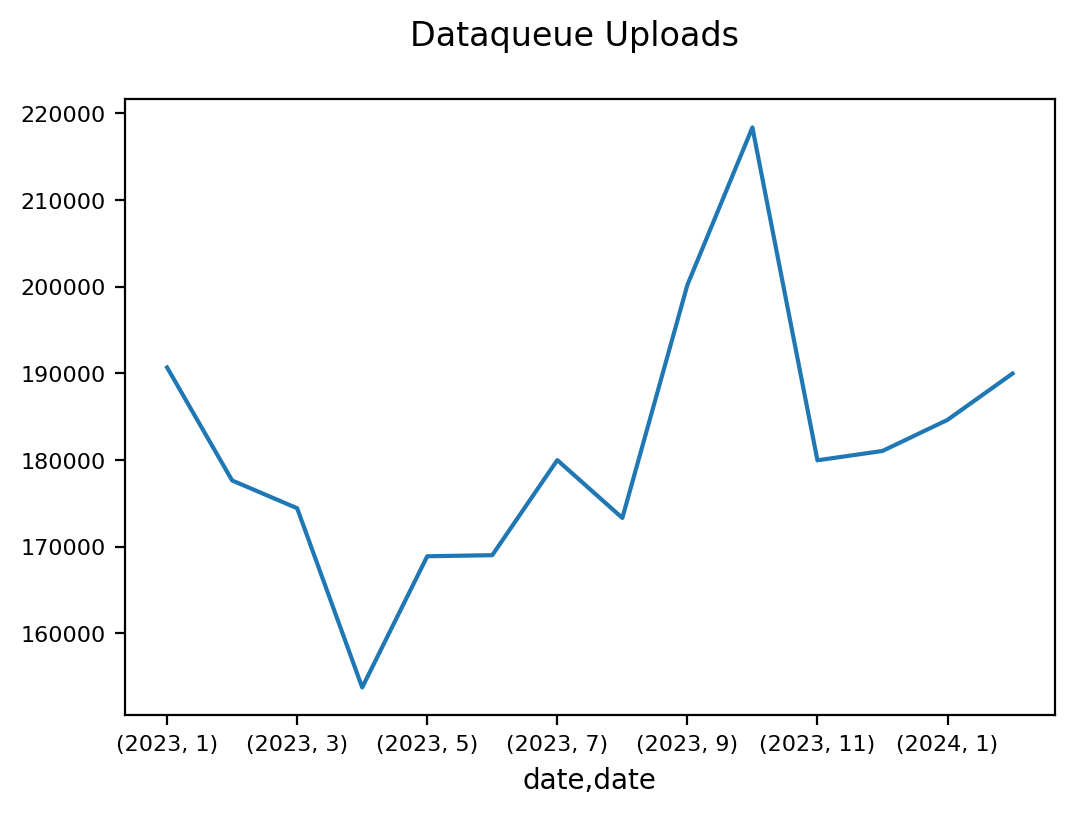

In [254]:
#dq_uploads.set_index('date', inplace=True)
#dq_uploads.plot()
#plt.show()
column = 'count'
#grp_c = data.groupby(groupby)[column].sum().to_frame().nlargest(n, column)
grp_c = dq_uploads.groupby([dq_uploads.date.dt.year, dq_uploads.date.dt.month])['count'].sum().to_frame()
grp_c

total = grp_c['count'].sum()
fig = plt.figure(figsize=(6,4), dpi=200)
ax = plt.subplot(111)
fig = grp_c.plot(kind='line', ax=ax, #autopct=lambda p: '{:00,d}'.format(int(round(p * total / 100)/adjust)*adjust), #'%1.1f%%', 
           fontsize=8, subplots=True, legend=False, ylabel='', title = 'Dataqueue Uploads')
plt.savefig('G:/My Drive/Smart/Documents/scaas-uploaders.png')
fig

In [267]:
server = pd.read_excel("G:/My Drive/Smart/Documents/2024-03-07-scaas-sites.xlsx")
#server_active = server.where((server['Monitoring'] == 'Active') & (server_active['InstallDate'] != '')).dropna(how='all')
#server_active['setup_date'] = pd.to_datetime(server_active['InstallDate'])
server
#g = server_active.groupby([server_active['Migration Date'].dt.year, server_active['Migration Date'].dt.month])['count'].sum().to_frame()

Sitename Version InstallDate Docker Server Monitoring
0                amazonasconnect   7.5.5  2022-03-27       Docker5     Active
1            argentinaapnconnect   7.5.5  2022-03-31       Docker5     Active
2            atewaforestconnect    7.5.5  2022-03-24       Docker5     Active
3            barrionuevoconnect    7.5.7  2022-04-18       Docker3     Active
4                    biliconnect     6.3  2022-04-03       Docker1     Active
..                           ...     ...         ...           ...        ...
225            wcsecuadorconnect   7.5.7  2024-02-09       Docker8     Active
226  marasianaconservancyconnect   7.5.7  2024-02-19       Docker8     Active
227                  cfesconnect   7.5.7  2024-02-28       Docker8     Active
228                   cfzconnect   7.5.7  2024-02-28       Docker8     Active
229       birdlifeUkraineConnect   7.5.7  2024-03-01       Docker7     Active

[230 rows x 5 columns]

In [287]:
server_active = server.where((server['Monitoring'] == 'Active') & (server['InstallDate'] != '')).dropna(how='all')
server_active['InstallDate'] = pd.to_datetime(server_active['InstallDate'])
grp_c = server_active.groupby([server_active.InstallDate.dt.year, server_active.InstallDate.dt.day])['Sitename'].count().to_frame()
grp_c


Sitename
InstallDate InstallDate          
2022        1                   2
            2                   2
            3                   6
            5                   1
            6                   2
...                           ...
2024        12                  1
            16                  1
            18                  1
            19                  1
            28                  2

[64 rows x 1 columns]

array([<Axes: xlabel='InstallDate,InstallDate'>], dtype=object)

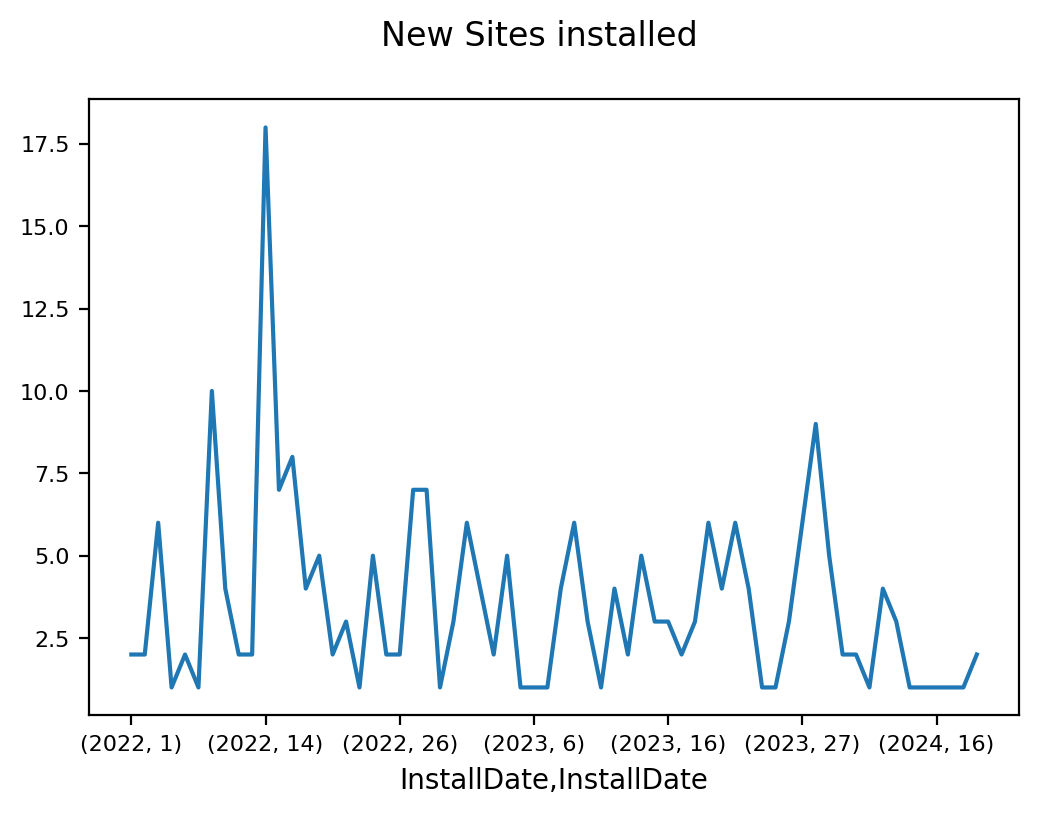

In [289]:
#total = grp_c['count'].sum()
fig = plt.figure(figsize=(6,4), dpi=200)
ax = plt.subplot(111)
fig = grp_c.plot(kind='line', ax=ax, #autopct=lambda p: '{:00,d}'.format(int(round(p * total / 100)/adjust)*adjust), #'%1.1f%%', 
           fontsize=8, subplots=True, legend=False, ylabel='', title = 'New Sites installed')
plt.savefig('G:/My Drive/Smart/Documents/scaas-new-sites.png')
fig

   month_year  installations_count
0     2022-02                    3
1     2022-03                   13
2     2022-04                   12
3     2022-05                    9
4     2022-06                    2
5     2022-07                   13
6     2022-08                    8
7     2022-09                   13
8     2022-10                   12
9     2022-11                   13
10    2022-12                    9
11    2023-01                    9
12    2023-02                    7
13    2023-03                   11
14    2023-04                    5
15    2023-05                   12
16    2023-06                    2
17    2023-07                   14
18    2023-08                   12
19    2023-09                   12
20    2023-10                    3
21    2023-11                   12
22    2023-12                    6
23    2024-01                    6
24    2024-02                    8
25    2024-03                    1


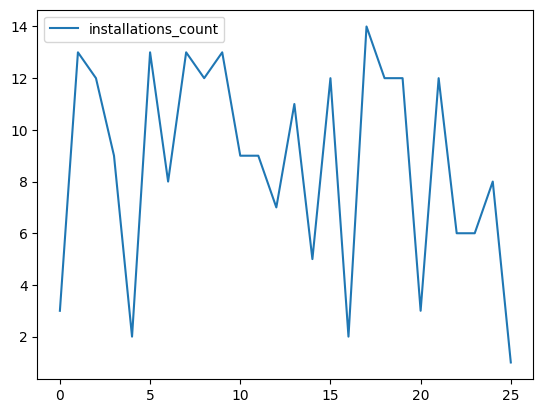

In [294]:
server_active = server.where((server['Monitoring'] == 'Active') & (server['InstallDate'] != '')).dropna(how='all')
server_active['InstallDate'] = pd.to_datetime(server_active['InstallDate'])
server_active['month_year'] = server_active['InstallDate'].dt.to_period('M')
installations_per_month = server_active.groupby('month_year').size().reset_index(name='installations_count')

# If you want the result sorted by date, you can do the following:
installations_per_month = installations_per_month.sort_values('month_year')

# Print or use the resulting DataFrame
print(installations_per_month)
#grp_c = server_active.groupby([server_active.InstallDate.dt.year, server_active.InstallDate.dt.day])['Sitename'].count().to_frame()
#grp_c
#installations_per_month.plot()
df = server_active

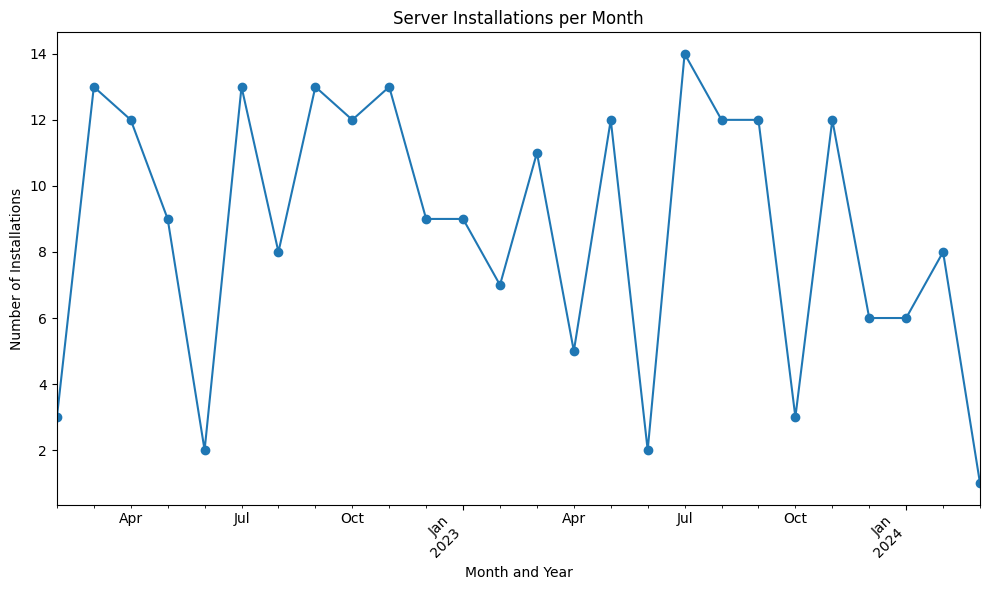

In [298]:
# Assuming df is your original DataFrame
df['InstallDate'] = pd.to_datetime(df['InstallDate'])
df['month_year'] = df['InstallDate'].dt.to_period('M')

# Plotting directly from the original DataFrame
plt.figure(figsize=(10, 6))
df.groupby('month_year').size().plot(marker='o')
plt.title('Server Installations per Month')
plt.xlabel('Month and Year')
plt.ylabel('Number of Installations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('G:/My Drive/Smart/Documents/scaas-monthly-installations.png')
plt.show()

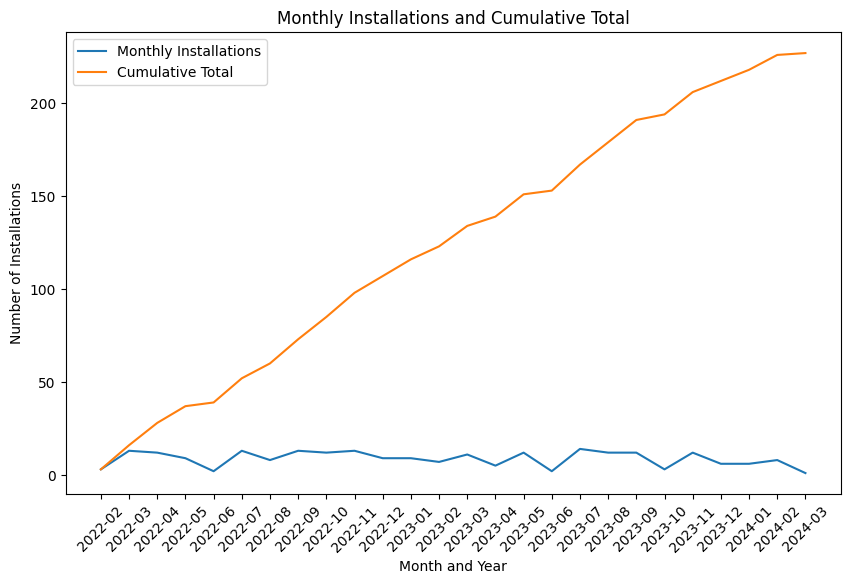

In [299]:
# Assuming 'df' is your DataFrame
# Convert 'installation_date' to datetime if it's not already in datetime format
df['InstallDate'] = pd.to_datetime(df['InstallDate'])

# Create a new column for month and year
df['month_year'] = df['InstallDate'].dt.to_period('M').astype(str)

# Group by month and year, then count the number of installations
installations_per_month = df.groupby('month_year').size().reset_index(name='installations_count')

# Calculate the cumulative total
installations_per_month['cumulative_total'] = installations_per_month['installations_count'].cumsum()

# Plotting
plt.figure(figsize=(10, 6))

# Plot monthly installations
plt.plot(installations_per_month['month_year'], installations_per_month['installations_count'], label='Monthly Installations')

# Plot cumulative total
plt.plot(installations_per_month['month_year'], installations_per_month['cumulative_total'], label='Cumulative Total')

plt.xlabel('Month and Year')
plt.ylabel('Number of Installations')
plt.title('Monthly Installations and Cumulative Total')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('G:/My Drive/Smart/Documents/scaas-new-sites.png')
plt.show()

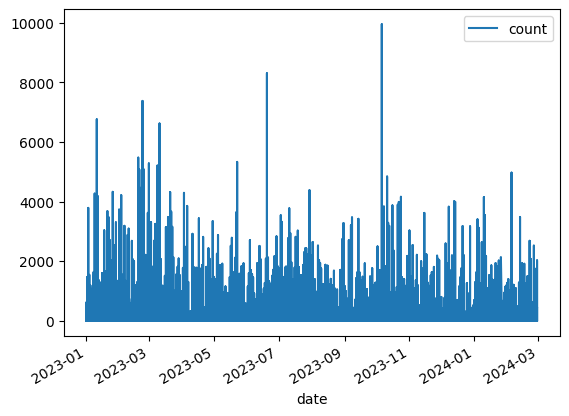

In [31]:
dq_complete.set_index('date', inplace=True)
dq_complete.plot()
plt.show()

In [32]:
#grp_c = dq_complete.groupby([dq_complete.date.dt.year, dq_complete.date.dt.month])['count'].sum().to_frame()
grp_c = dq_complete.groupby(pd.Grouper(key='date', freq='M'))['count'].sum()
grp_c.plot(xlabel='Date', ylabel='Dataqueue processing/Month')

KeyError: 'The grouper name date is not found'

<Axes: xlabel='sitename,date,date'>

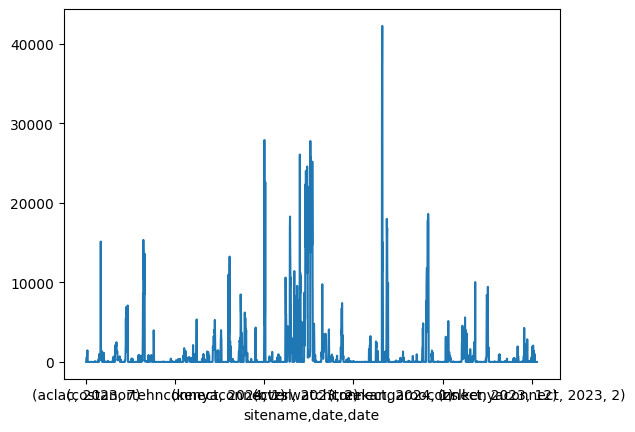

In [33]:
grp_c.plot()

In [34]:
grp_c = dq_uploads.groupby(pd.Grouper(key='date', freq='M'))['count'].sum()
grp_c.plot(xlabel='Date', ylabel='Uploads to Dataqueue/Month')

KeyError: 'The grouper name date is not found'

In [207]:
def create_pie_chart(data, groupby, column, title, filename, n=10, adjust = 1000):
    grp_c = data.groupby(groupby)[column].sum().to_frame().nlargest(n, column)
    
    total = grp_c[column].sum()
    fig = plt.figure(figsize=(6,6), dpi=200)
    ax = plt.subplot(111)
    
    fig = grp_c.plot(kind='pie', ax=ax, autopct=lambda p: '{:00,d}'.format(int(round(p * total / 100)/adjust)*adjust), #'%1.1f%%', 
               startangle=270, fontsize=8, subplots=True, legend=False, ylabel='', title = title)
    plt.savefig(filename)
    return fig

array([<Axes: >], dtype=object)

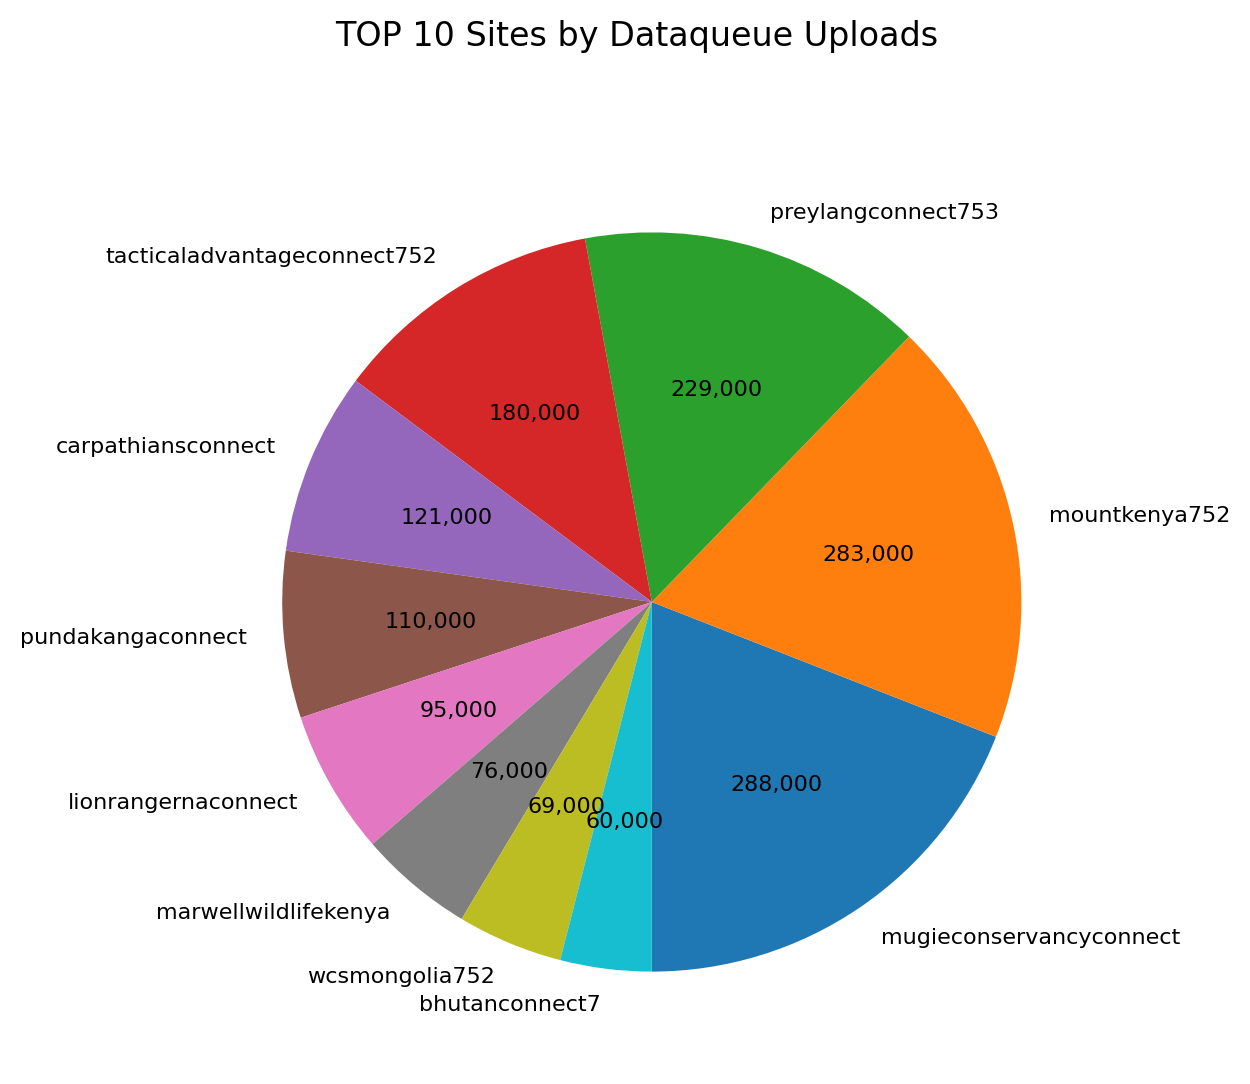

In [208]:
create_pie_chart(dq_uploads, 'sitename', 'count', 'Top 10 Sites by Dataqueue Uploads', 'G:/My Drive/Smart/Documents/scaas-uploaders.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

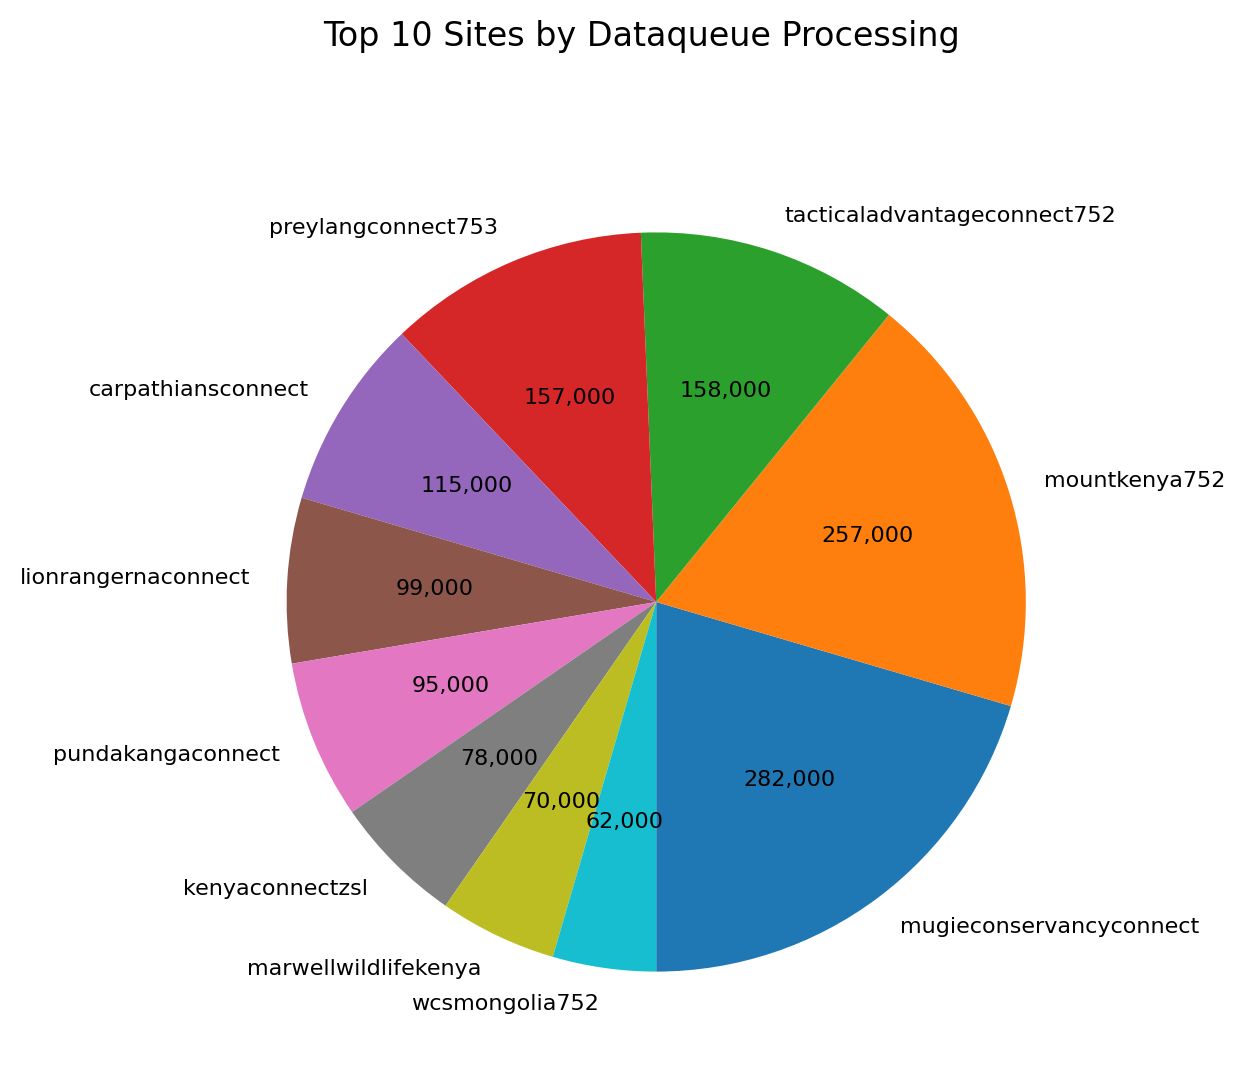

In [209]:
create_pie_chart(dq_complete, 'sitename', 'count', 'Top 10 Sites by Dataqueue Processing', 'G:/My Drive/Smart/Documents/scaas-datqueue-processors.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

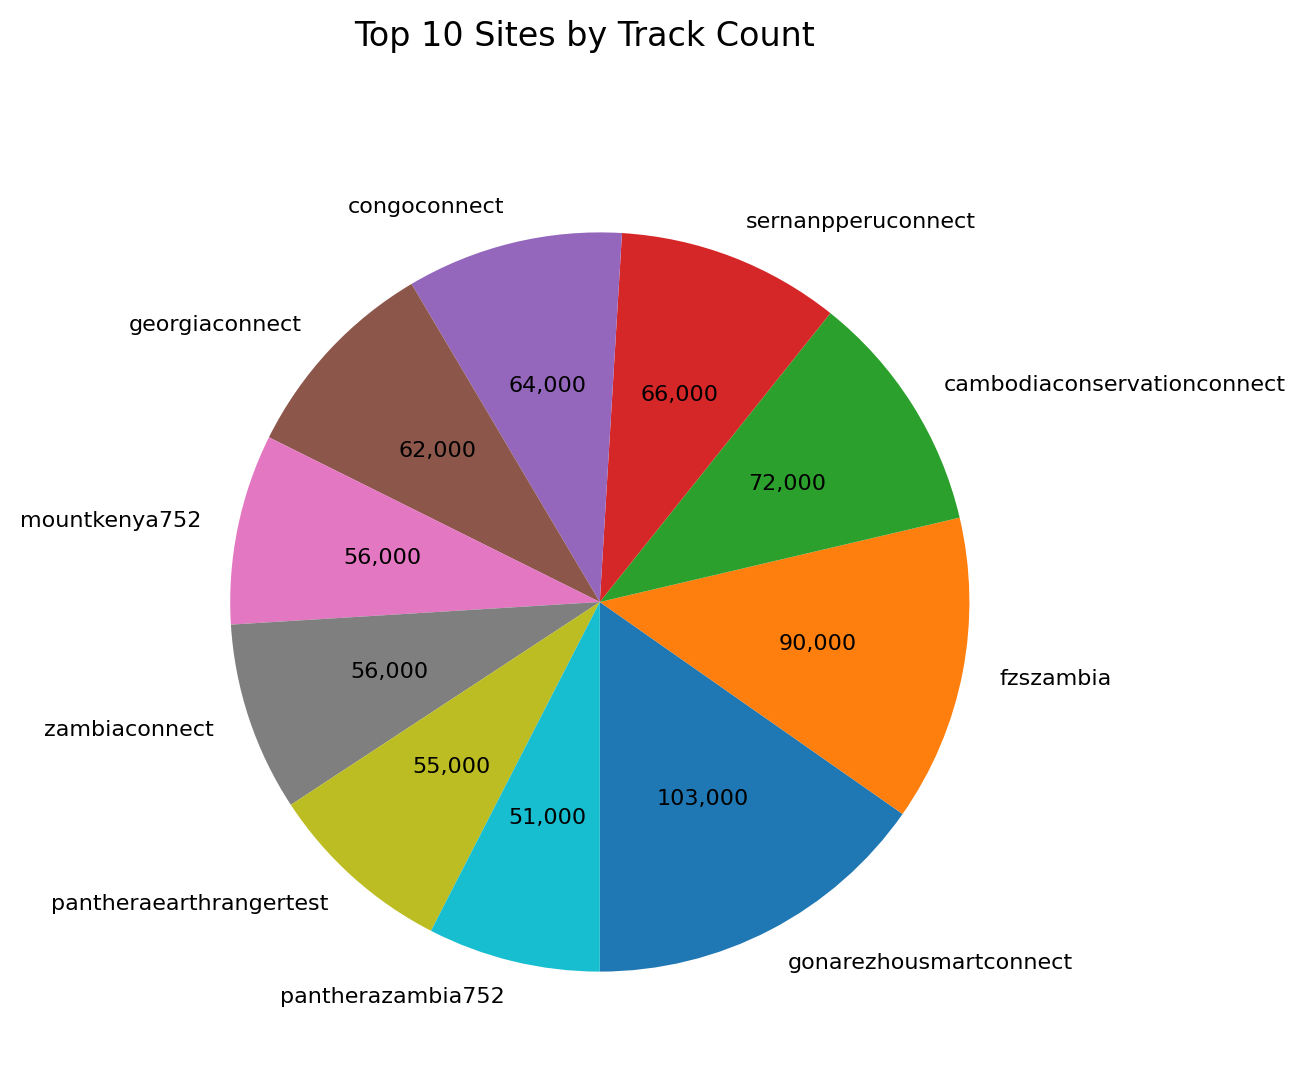

In [210]:
create_pie_chart(df_active, 'sitename', 'track_count', 'Top 10 Sites by Track Count', 'G:/My Drive/Smart/Documents/scaas-track-count.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

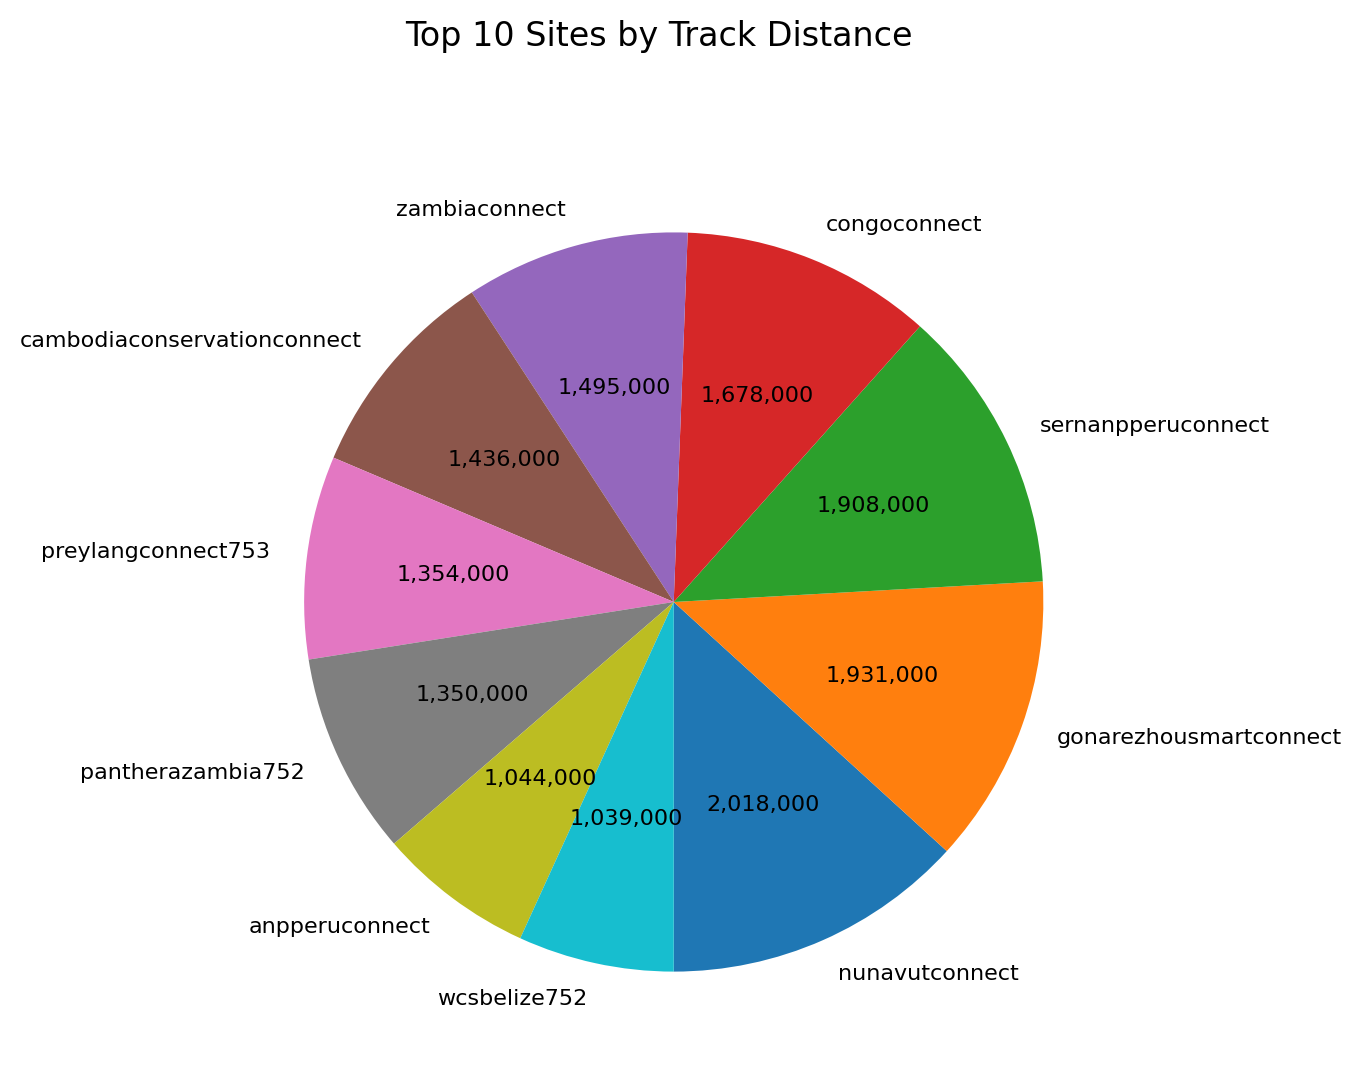

In [211]:
create_pie_chart(df_active, 'sitename', 'track_distance', 'Top 10 Sites by Track Distance', 'G:/My Drive/Smart/Documents/scaas-track-distance.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

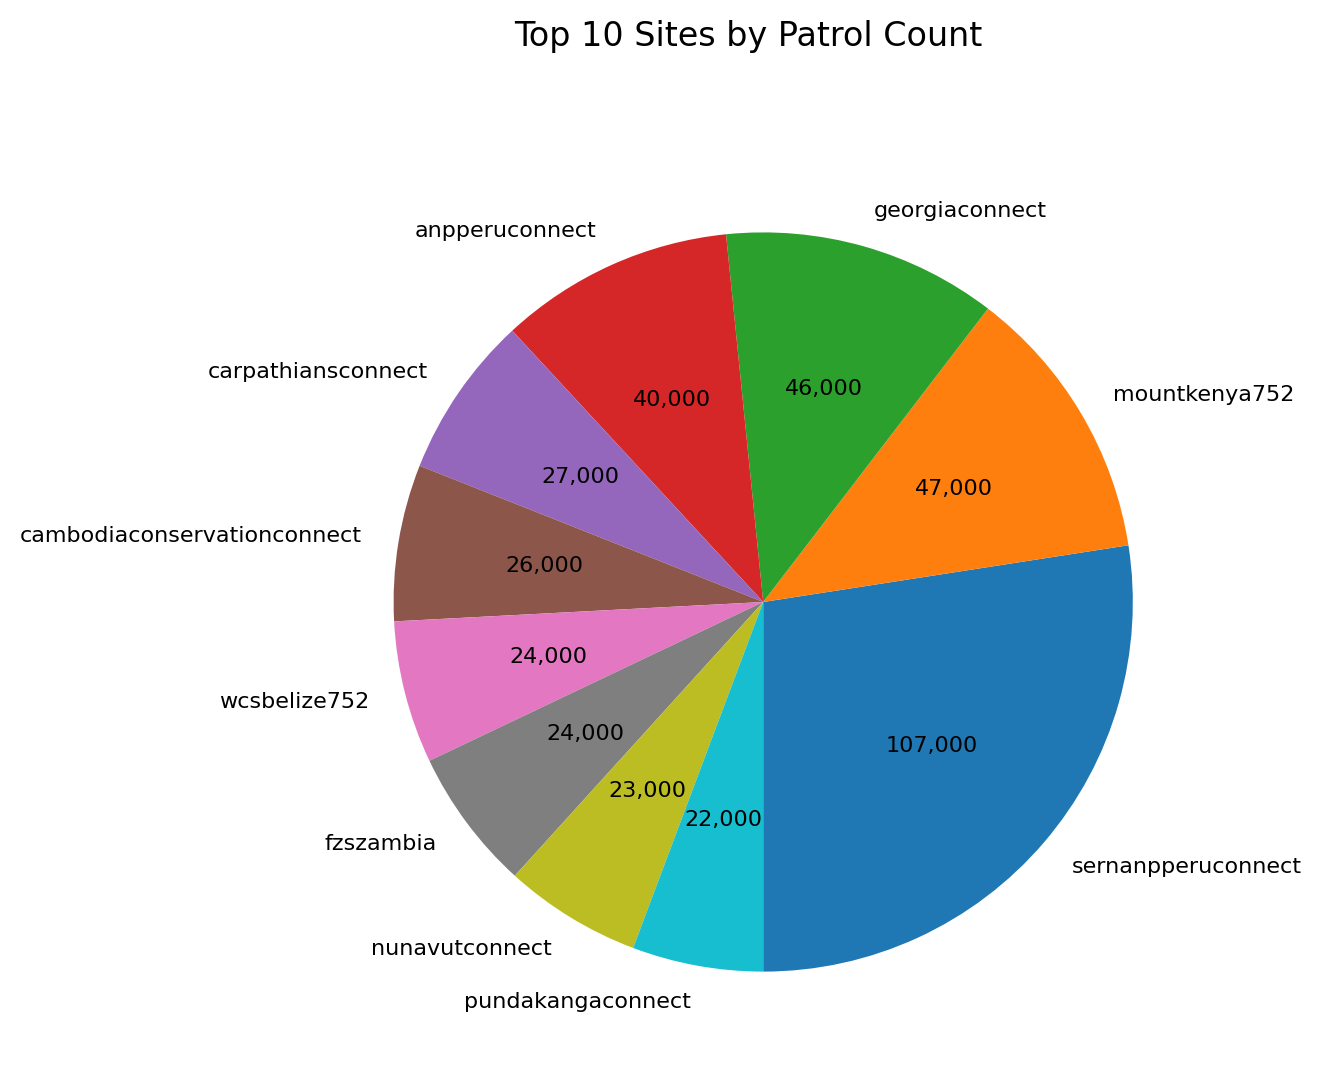

In [212]:
create_pie_chart(df_active, 'sitename', 'patrol_count', 'Top 10 Sites by Patrol Count', 'G:/My Drive/Smart/Documents/scaas-patrol-count.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

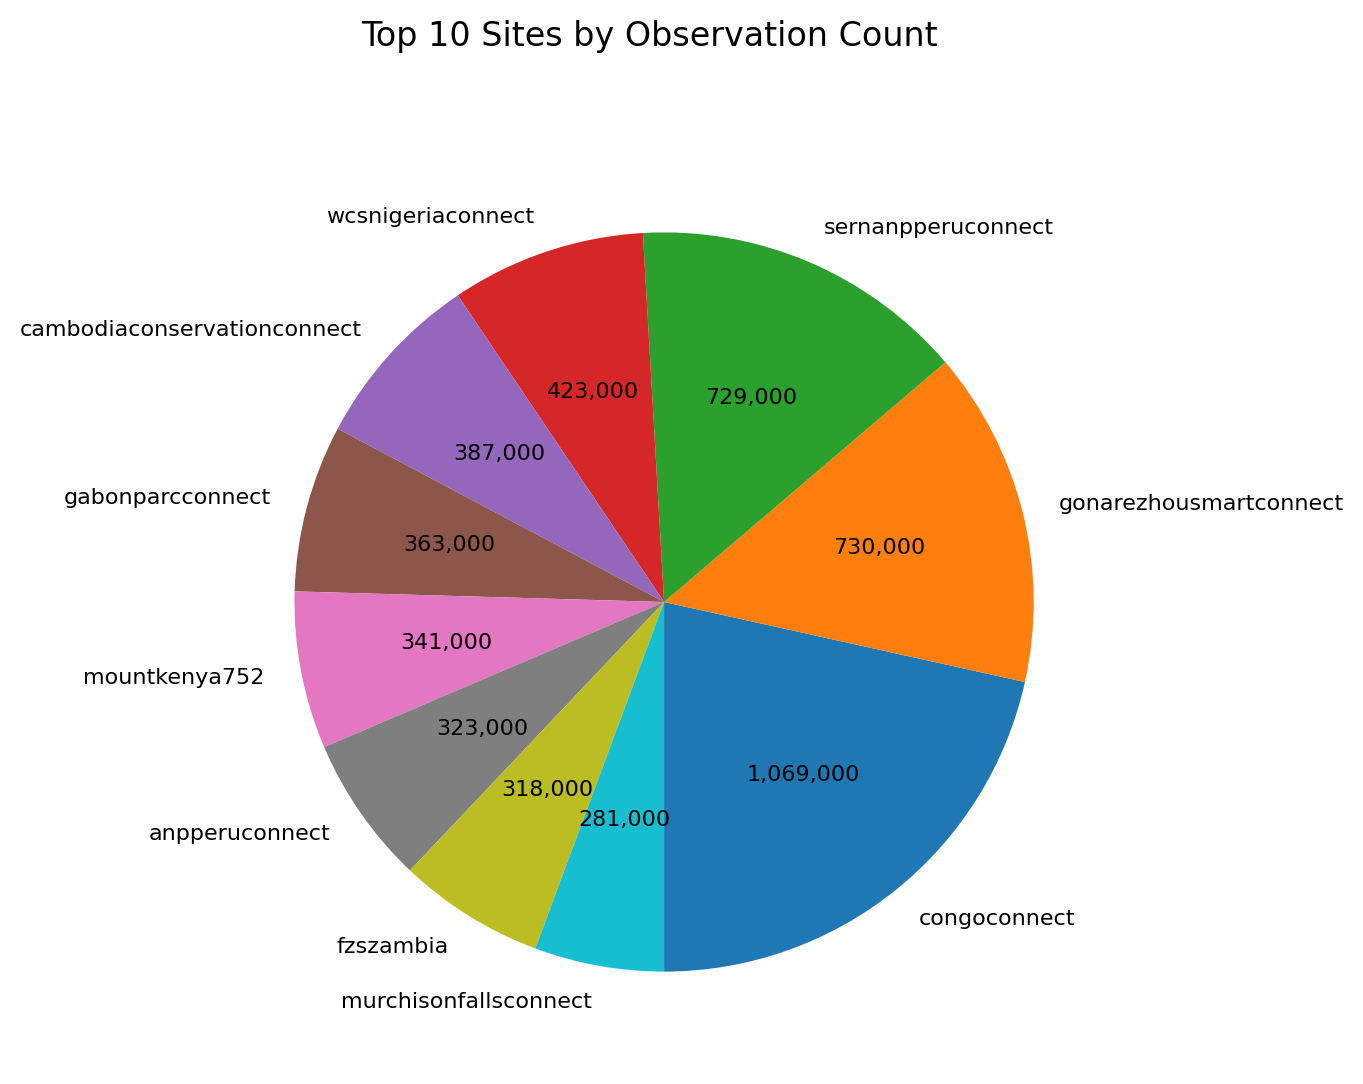

In [213]:
create_pie_chart(df_active, 'sitename', 'waypoint_count', 'Top 10 Sites by Observation Count', 'G:/My Drive/Smart/Documents/scaas-observation-count.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

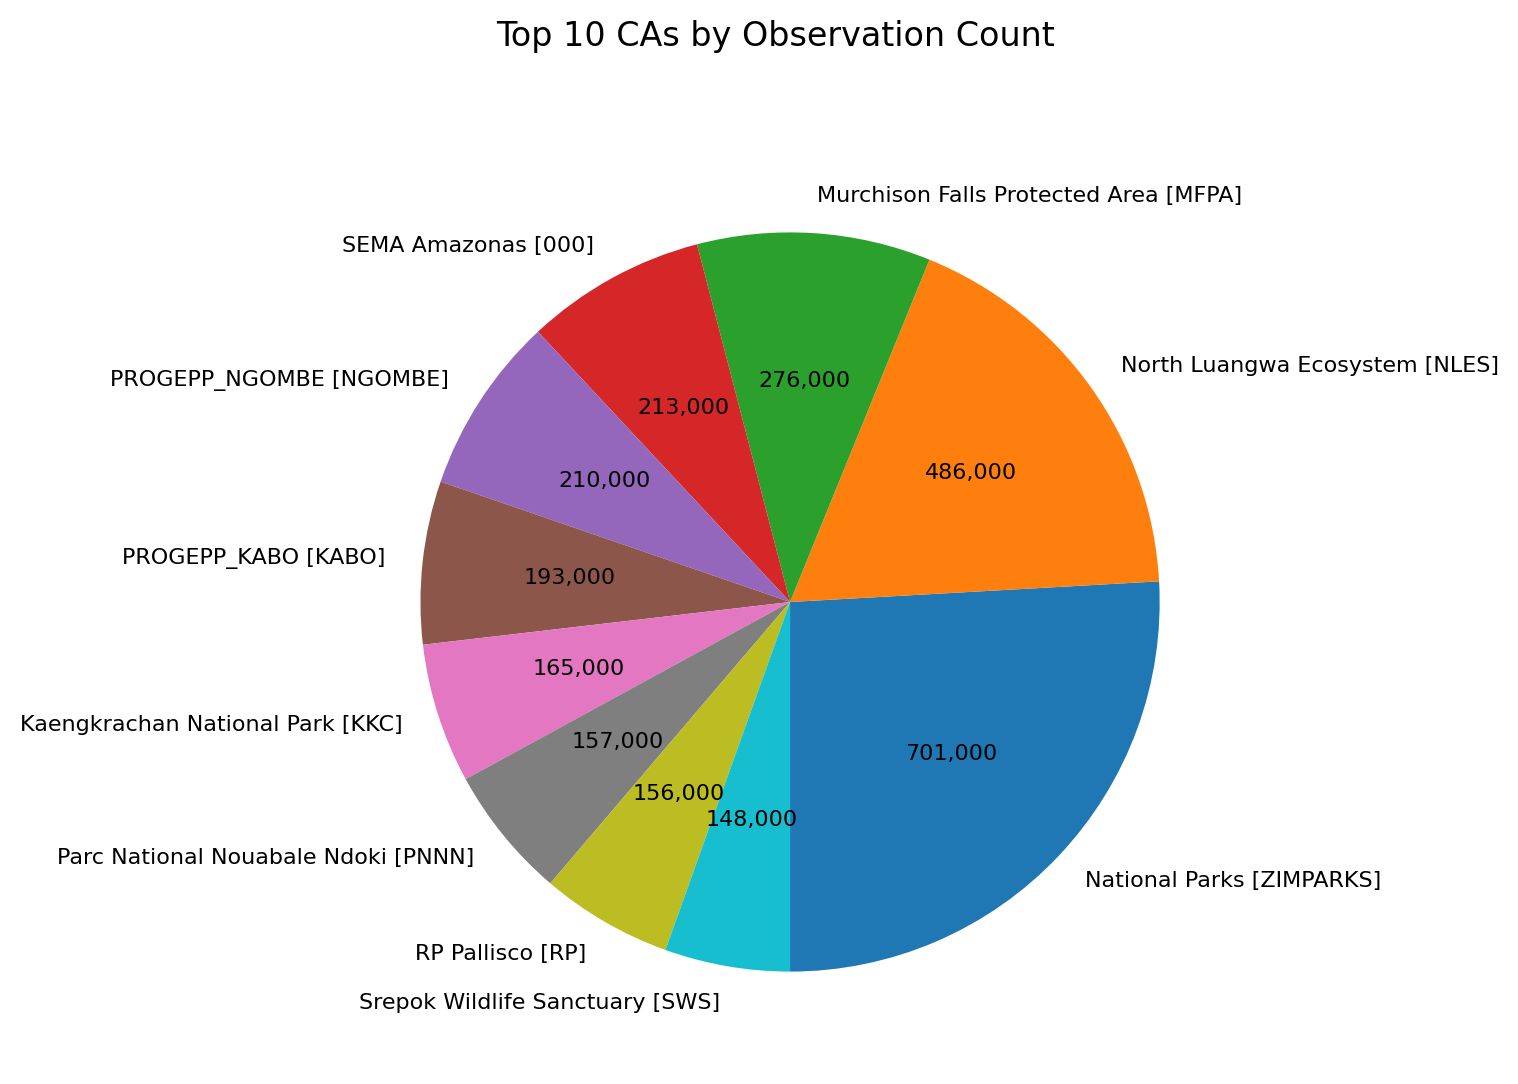

In [214]:
create_pie_chart(df_active, 'ca_name', 'waypoint_count', 'Top 10 CAs by Observation Count', 'G:/My Drive/Smart/Documents/scaas-cas-observation-count.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

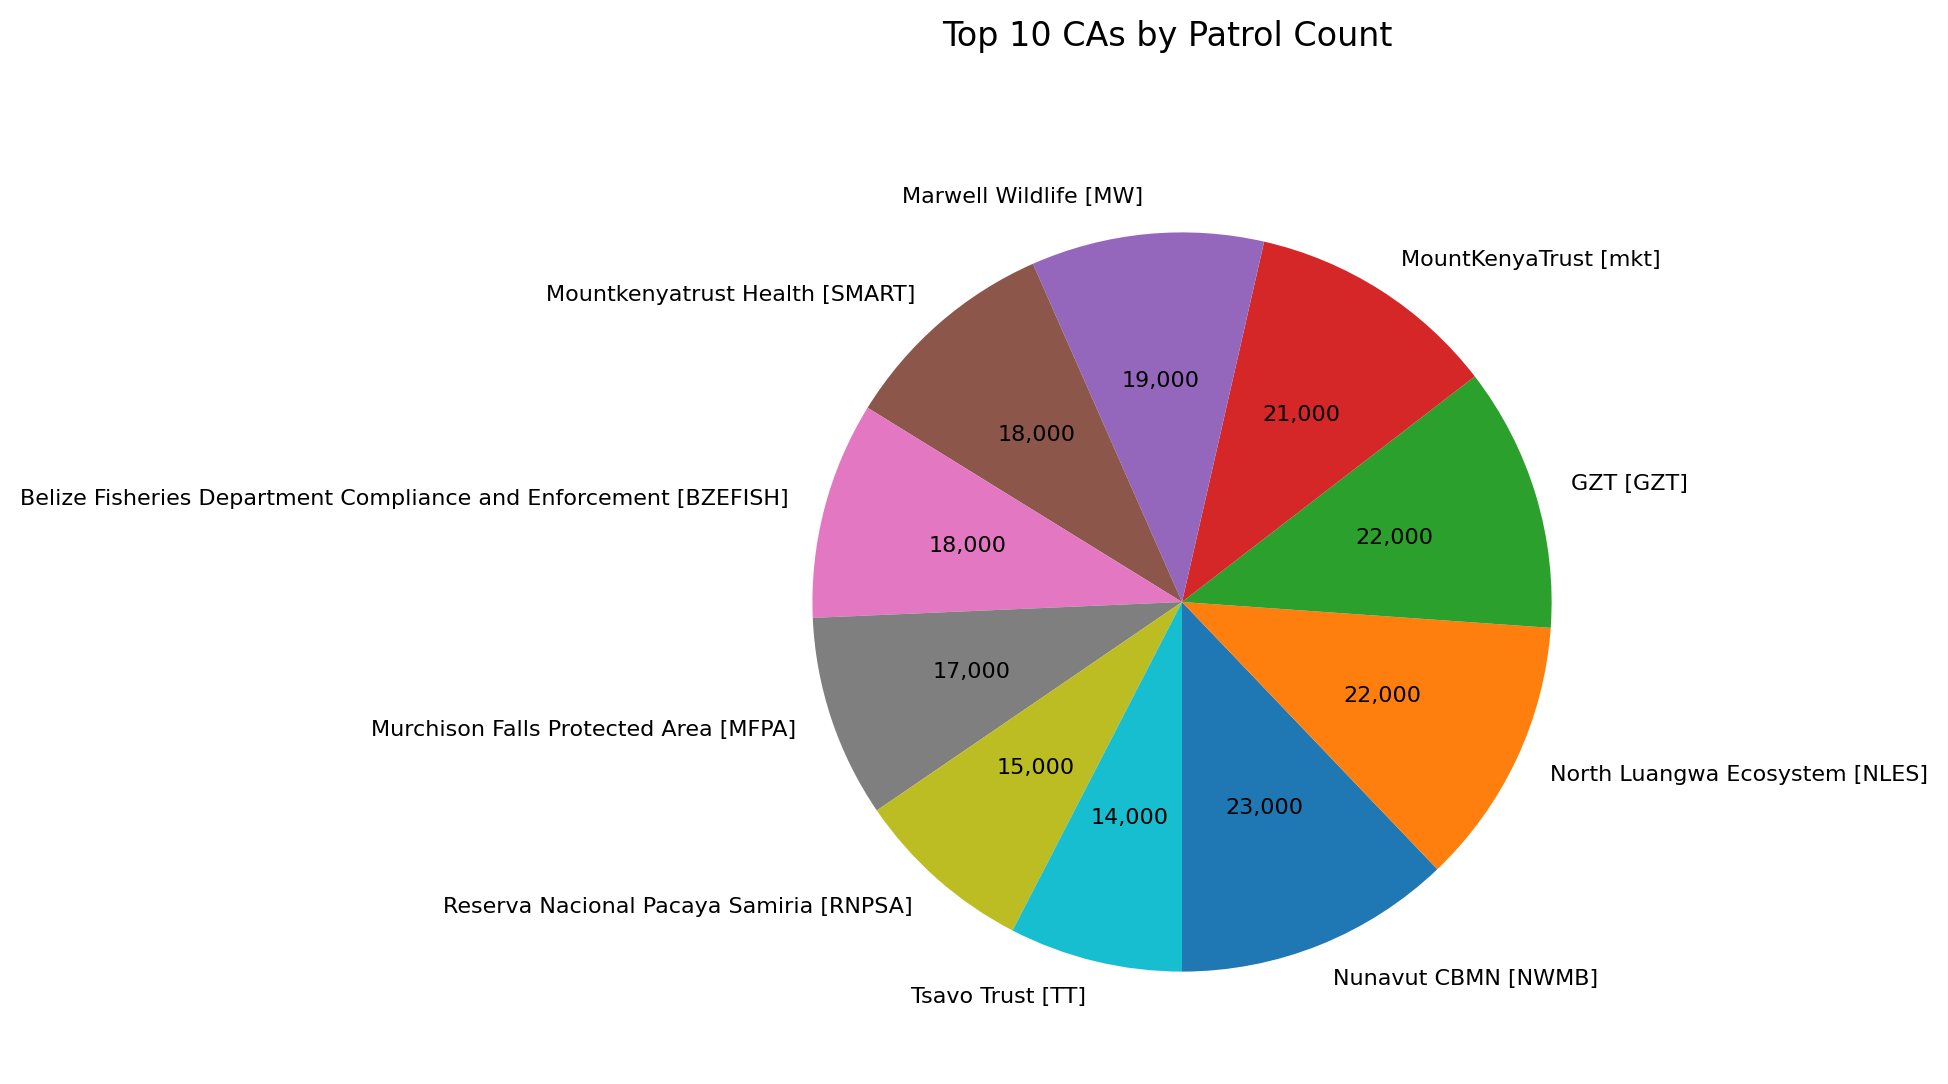

In [215]:
create_pie_chart(df_active, 'ca_name', 'patrol_count', 'Top 10 CAs by Patrol Count', 'G:/My Drive/Smart/Documents/scaas-cas-patrol-count.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

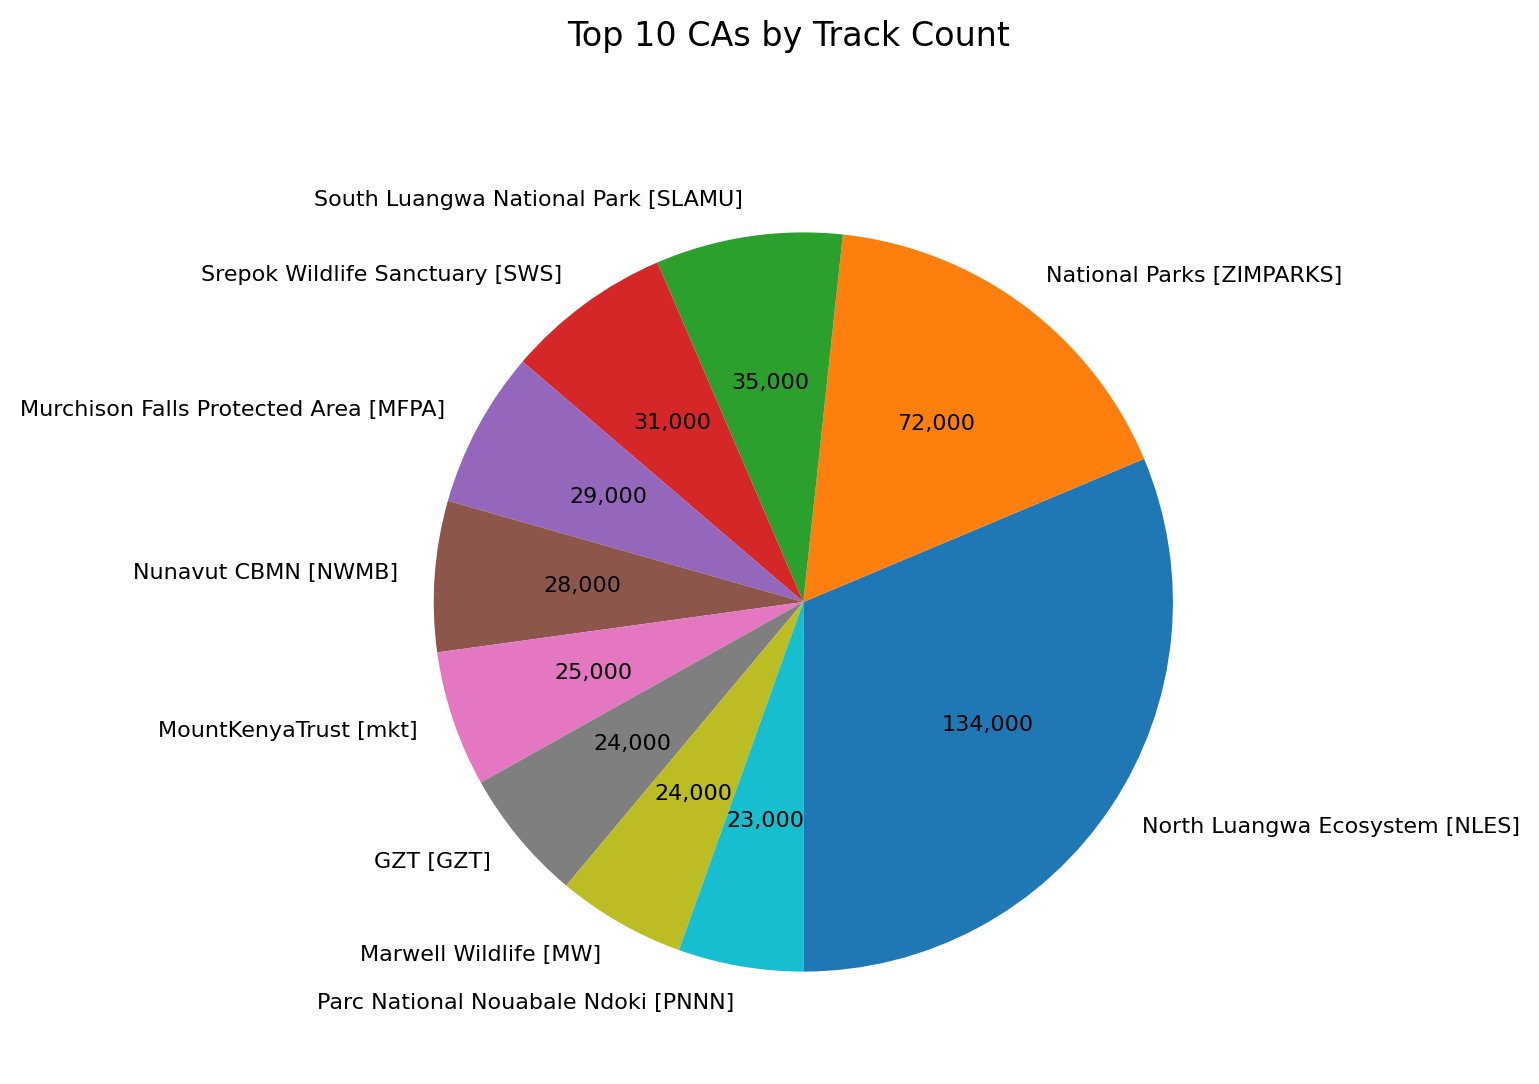

In [216]:
create_pie_chart(df_active, 'ca_name', 'track_count', 'Top 10 CAs by Track Count', 'G:/My Drive/Smart/Documents/scaas-cas-track-count.png', n=10, adjust = 1000)

array([<Axes: >], dtype=object)

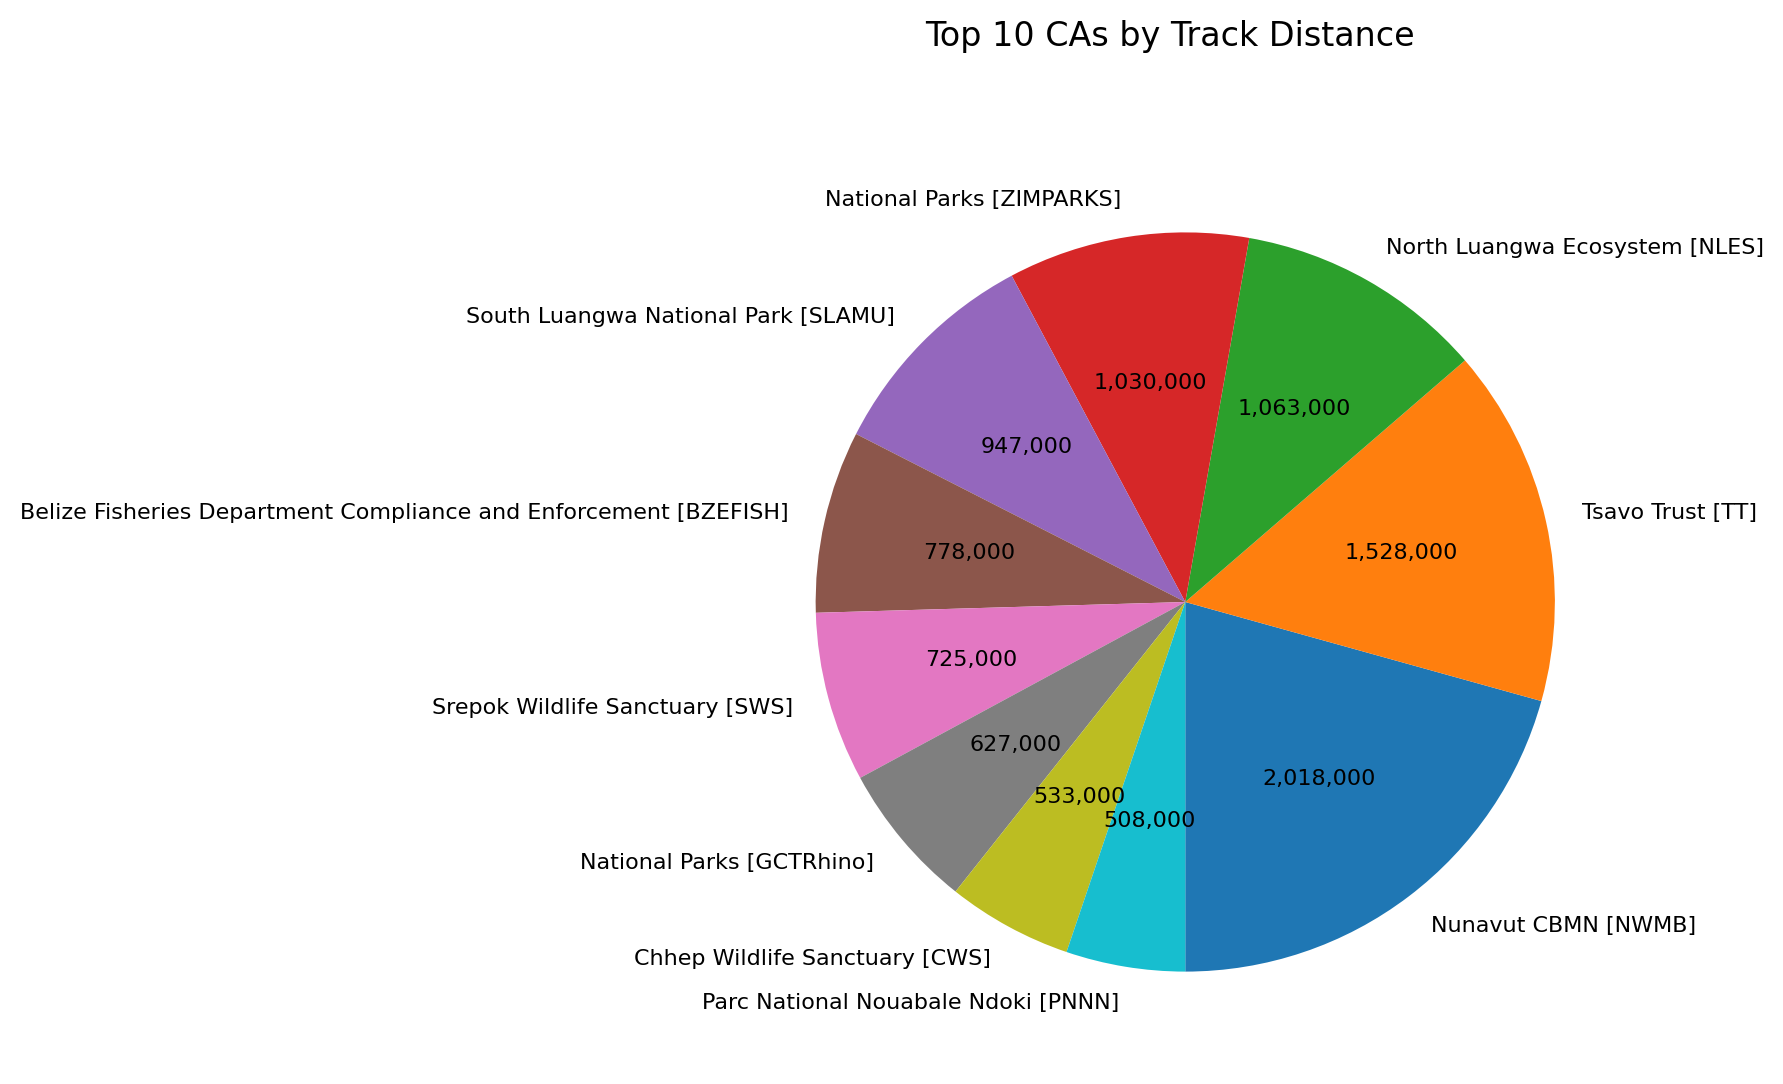

In [217]:
create_pie_chart(df_active, 'ca_name', 'track_distance', 'Top 10 CAs by Track Distance', 'G:/My Drive/Smart/Documents/scaas-cas-track-distance.png', n=10, adjust = 1000)

In [ ]:
# Match Registry with real data
"G:\My Drive\Smart\Documents\SMART CA DB.xlsx"